StratifiedCV 함수 변경

- 스케일은 훈련 데이터에 대해서만 fit이 되어야 한다. 그렇지 않으면 과적합 모델로, 성능 사기친 모델이 된다.

-  하지만, 데스트 데이터는 훈련데이터에서한 fit한  sale에서 transform 해야한다. 
  
- ver2에서는, 과적합을 막기 위해 5차교차검증을 하느라 train 데이터를 part_train, valid로 나누었는데

  valid로 검증시에도 과적합된 성능이 나오지 않기 위해서, 5차 검증마다 scale을 part_train 으로 fit 해서 했다. 
  
  하지만, 그러면 나중에 test 데이터에 transfrom할 스케일이 일정하지 않다.


==> 그래서, 스케일은 train 데이터에서 한번만 하는 것으로 변경해보자.


이상치 제거

# Summary of Steps taken and performance achieved

Multiple models with different levels of complexity were attempted. The dependent and independent variables seem to have a nonlinear relationship as the performance of models improved with increasing complexity. MAPE was selected as the evaluation metric.Regularization, feature selection and hyper-parameter tuning was employed to improve the model performance. The models attempted are

1. Ridge and Lasso
2. Gradient Boosting
3. Random Forest
4. XGboost
5. Support Vector Machine
6. MLPRegression
7. Stacking - ensemble of the best estimators of the above tuned models with a meta regressor (i.e. Ridge) which gave the best result (MAPE of less than 10)

https://github.com/Pranov1984/Prediction-of-cement-compressive-strength-using-stacked-ensemble-modelling/blob/master/Concrete%20Compressive%20Strength%20Prediction-V3.ipynb

## Data

#### Load Data

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D   
import matplotlib.ticker as mticker
from scipy.stats import reciprocal
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate #Additional scklearn functions
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from matplotlib.pylab import rcParams

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas.plotting import scatter_matrix

from copy import deepcopy

import tensorflow as tf
from sklearn.linear_model import LinearRegression, Ridge,LassoCV, Lasso, RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from tensorflow import keras
from keras.models import Sequential  # 선형 네트워크 스택을 정의하는데 사용함
from keras.layers import Dense  # Dense, 피드포워드 완전 연결 레이어

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR

import warnings
warnings.filterwarnings(action="ignore")

import time

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from pandas.core.frame import DataFrame
df = pd.read_csv('./flyash.csv')

df.drop('ID', axis=1, inplace=True)
df.drop('LOI', axis=1, inplace=True)
df.drop('Amorphous Alumina', axis=1, inplace=True)
df.drop('Amorphous Silica', axis=1, inplace=True)

df

,Al2O3,CaO,Fe2O3,SiO2,MgO,Na2O+0.658K2O,Sum of amorphous aluminosilicates
0,20.9,2.7,5.2,64.8,1.4,1.7,60.00
1,20.8,2.7,5.0,65.0,1.4,1.8,58.00
2,20.9,5.7,8.2,55.9,2.0,2.4,60.00
3,21.3,4.0,6.4,59.5,1.5,1.2,44.00
4,20.1,4.1,8.7,58.8,2.0,1.8,52.00
...,...,...,...,...,...,...,...
57,22.9,5.5,7.7,55.9,1.8,2.2,55.20
58,21.2,3.9,6.3,62.7,1.5,0.8,66.70
59,22.9,6.4,9.0,52.0,1.8,2.9,53.92
60,20.1,3.4,5.6,53.7,0.9,1.9,48.58


#### Data Distribution

In [3]:
features = np.array(df.columns)
features

array(['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O',
       'Sum of amorphous aluminosilicates'], dtype=object)

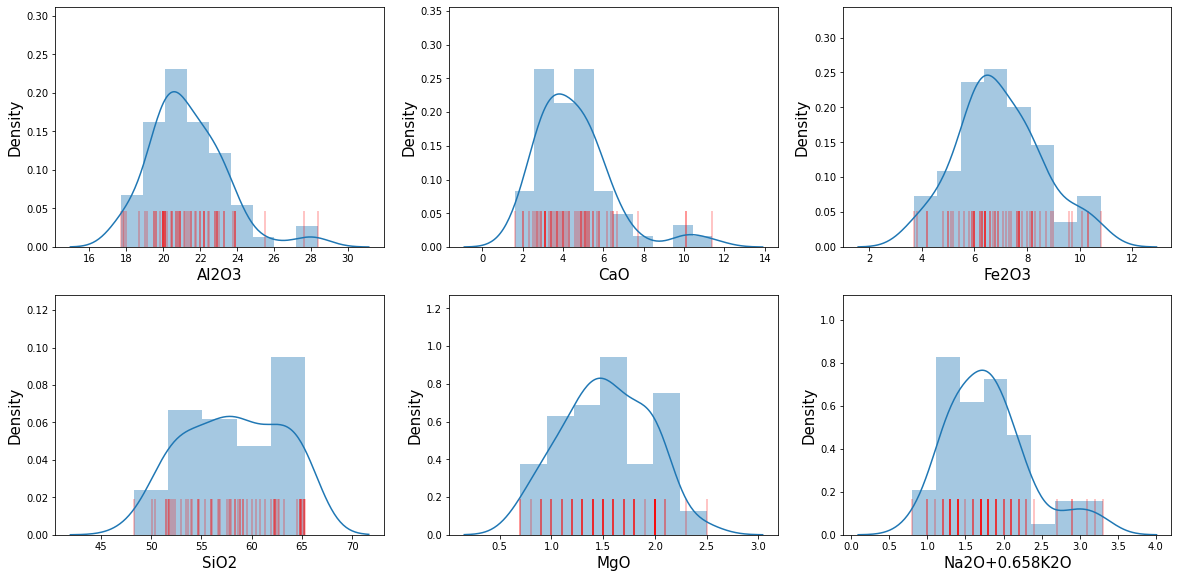

In [4]:
var=np.arange(1,len(df.columns))
var

figsize(20, 15)
for i in var:
    plt.subplot(3,3,i)
    p = sns.distplot(df.iloc[:,(i-1)], rug=True,
                     rug_kws = {'color':'r', 'alpha':0.3, 'linewidth':1.5, 'height':0.15})      # bins = n_samples, dist
    p.set_xlabel(features[i-1], fontsize=15)
    p.set_ylabel('Density', fontsize=15)

plt.savefig('./distrb_input_feature.png')

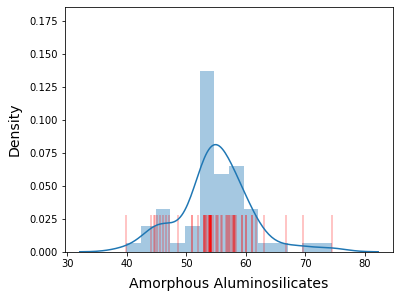

In [5]:
plt.subplots(figsize=(6,4.5))
p = sns.distplot(df.iloc[:,6], rug=True,
                  rug_kws = {'color':'r', 'alpha':0.3, 'linewidth':1.5, 'height':0.15})      # bins = n_samples, dist
p.set_xlabel('Amorphous Aluminosilicates', fontsize=14, labelpad=8)
p.set_ylabel('Density', fontsize=14, labelpad=8)

plt.subplots_adjust(left=0.14)
plt.savefig('./distrb_output_feature.png')

In [6]:
df.iloc[:,:6].describe()

,Al2O3,CaO,Fe2O3,SiO2,MgO,Na2O+0.658K2O
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,21.319355,4.529032,6.966129,58.222581,1.525806,1.796774
std,2.073236,1.895931,1.611124,4.810147,0.411688,0.539571
min,17.700000,1.600000,3.700000,48.300000,0.700000,0.800000
25%,20.000000,3.150000,6.000000,54.250000,1.225000,1.400000
50%,20.900000,4.150000,6.750000,58.300000,1.500000,1.700000
75%,22.475000,5.275000,7.950000,62.300000,1.800000,2.075000
max,28.400000,11.400000,10.800000,65.300000,2.500000,3.300000


In [7]:
df.iloc[:,6].describe()

count    62.000000
mean     54.821613
std       5.956899
min      39.900000
25%      53.037500
50%      54.085000
75%      57.937500
max      74.400000
Name: Sum of amorphous aluminosilicates, dtype: float64

#### **Outliers



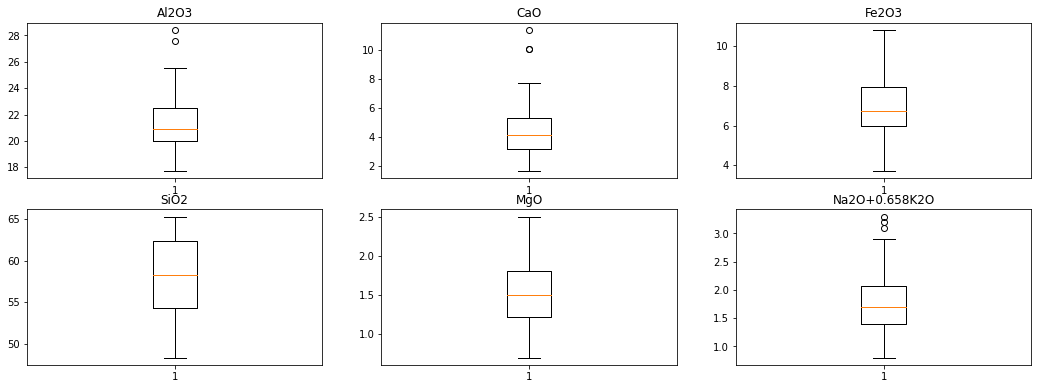

In [9]:
figsize(18, 20)
for i in var:
    plt.subplot(6,3,i)
    plt.boxplot(df.iloc[:,(i-1)])
    plt.title(df.columns[i-1])

plt.savefig('./outliers.png')

A few variables a have some outliers. There are various methods of treating outliers. In this case, I am capping the outliers to the maximum possible value that is not an outlier.

In [21]:
# Q1=np.percentile(df['Al2O3'],25)
# Q3=np.percentile(df['Al2O3'],75)
# IQR=Q3-Q1
# UL=Q3+1.5*IQR
# df.Al2O3=np.where(df.Al2O3>UL, UL, df.Al2O3)

In [22]:
# Q1=np.percentile(df['CaO'],25)
# Q3=np.percentile(df['CaO'],75)
# IQR=Q3-Q1
# UL=Q3+1.5*IQR
# df.CaO=np.where(df.CaO>UL, UL, df.CaO)

In [23]:
# Q1=np.percentile(df['Na2O+0.658K2O'],25)
# Q3=np.percentile(df['Na2O+0.658K2O'],75)
# IQR=Q3-Q1
# UL=Q3+1.5*IQR
# df['Na2O+0.658K2O'] = np.where(df['Na2O+0.658K2O'] > UL, UL, df['Na2O+0.658K2O'])

## Stratified Sampling

Multicollinearity 해결을 위해 PCA 하기 전에

표준화를 먼저해야한다.

표준화는 train data에 fit 해야하기 때문에

그 전에 Sampling 먼저 한다.

In [8]:
tf.random.set_seed(21) 
np.random.seed(21)

In [9]:
dist = [0.,
        df['Sum of amorphous aluminosilicates'].quantile(q=0.2,interpolation='nearest'),
        df['Sum of amorphous aluminosilicates'].quantile(q=0.4,interpolation='nearest'),
        df['Sum of amorphous aluminosilicates'].quantile(q=0.6,interpolation='nearest'),
        df['Sum of amorphous aluminosilicates'].quantile(q=0.8,interpolation='nearest'),
        np.inf]


df['Sum of amorphous aluminosilicates Cat'] = pd.cut(df['Sum of amorphous aluminosilicates'],    # Amorphous content 정도에 대한 카테고리 설정
                                     bins=dist, 
                                     labels=[1,2,3,4,5])

2    15
1    13
4    12
5    12
3    10
Name: Sum of amorphous aluminosilicates Cat, dtype: int64


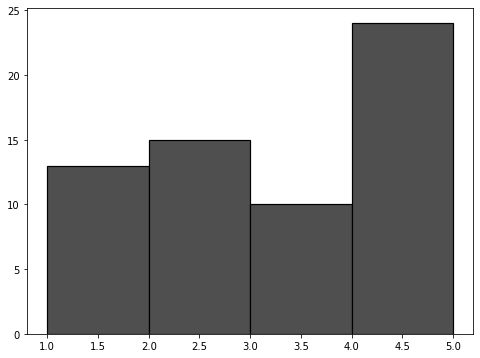

In [10]:
# check 
print(df['Sum of amorphous aluminosilicates Cat'].value_counts())
figsize(8,6)
df['Sum of amorphous aluminosilicates Cat'].hist(color='#4F4F4F', grid=False, bins=4, edgecolor='black', linewidth=1.2)

In [11]:
# Sampling based on caterogries
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df['Sum of amorphous aluminosilicates Cat']):
    strat_train = df.loc[train_idx]
    strat_test = df.loc[test_idx]

In [12]:
print(strat_train.shape, strat_test.shape)

(49, 8) (13, 8)


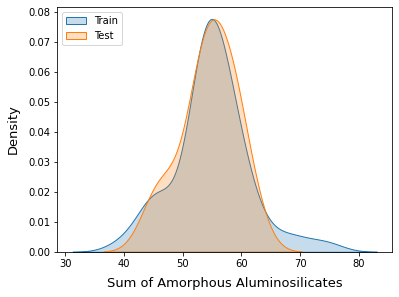

In [13]:
plt.figure(figsize=(6, 4.5))
sns.kdeplot(strat_train['Sum of amorphous aluminosilicates'], fill=True, label="Train")
sns.kdeplot(strat_test['Sum of amorphous aluminosilicates'], fill=True,  label="Test")

plt.legend(loc='upper left')
plt.xlabel('Sum of Amorphous Aluminosilicates', fontsize=13, labelpad=8)
plt.ylabel('Density', fontsize=13, labelpad=8)
# plt.show()

plt.savefig('./stratified_sampling.png')

In [14]:
# setting
for df_ in (strat_train, strat_test):
    # set_.drop('Sum of amorphous aluminosilicates Cat', axis=1, inplace=True)
    df_.reset_index(drop=True, inplace=True)
    df_['Sum of amorphous aluminosilicates'] = df_['Sum of amorphous aluminosilicates'].round()


#####(Versus Ordinary Sampling)

In [15]:
X = df.drop('Sum of amorphous aluminosilicates', axis=1)
y = df['Sum of amorphous aluminosilicates']

sampling_X_train, sampling_X_test, sampling_y_train, sampling_y_test = train_test_split(X, y, test_size=0.2, random_state=42)


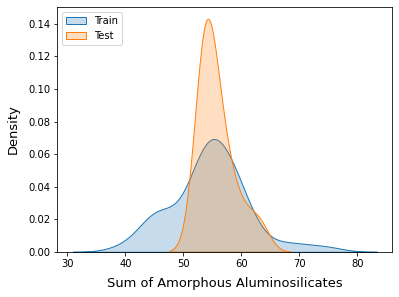

In [16]:
plt.figure(figsize=(6, 4.5))
sns.kdeplot(sampling_y_train, fill=True, label="Train")
sns.kdeplot(sampling_y_test, fill=True,  label="Test")

plt.legend(loc='upper left')
plt.xlabel('Sum of Amorphous Aluminosilicates', fontsize=13, labelpad=8)
plt.ylabel('Density', fontsize=13, labelpad=8)
# plt.show()

plt.savefig('./nomal_sampling.png')

_strat_train  # round 안 된 train set

strat_train # round 된 train set

strat_test # round 된 test set

df     # round 된 df

## Feature Scale

In [17]:
X_train = strat_train.drop('Sum of amorphous aluminosilicates', axis=1)
X_train.drop('Sum of amorphous aluminosilicates Cat', axis=1, inplace=True)
y_train = pd.DataFrame(strat_train['Sum of amorphous aluminosilicates'])

X_test = strat_test.drop('Sum of amorphous aluminosilicates', axis=1)
X_test.drop('Sum of amorphous aluminosilicates Cat', axis=1, inplace=True)
y_test = pd.DataFrame(strat_test['Sum of amorphous aluminosilicates'])

In [18]:
scalerX = StandardScaler().fit(X_train)  
scalery = StandardScaler().fit(y_train)


X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)

X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

# # Save scaler
# joblib.dump(scalerX, "./scalerX.save") 
# joblib.dump(scalery, "./scalery.save") 

# # And load...
# scaler = joblib.load(scaler_filename) 

In [19]:
X_columns = df.iloc[:,0:6].columns
y_column = 'Sum of amorphous aluminosilicates'

In [20]:
# 학습 가능한 데이터로 변환
y_train = np.ravel(y_train)
X_train = pd.DataFrame(X_train, columns=X_columns)
y_train = pd.Series(y_train, name='Sum of amorphous aluminosilicates')

y_test = np.ravel(y_test)
X_test = pd.DataFrame(X_test, columns=X_columns)
y_test = pd.Series(y_test, name='Sum of amorphous aluminosilicates')

In [21]:
sc_strat_train = pd.DataFrame.copy(X_train)
sc_strat_train[y_column] = y_train
sc_strat_train['Sum of amorphous aluminosilicates Cat'] = strat_train['Sum of amorphous aluminosilicates Cat']

sc_strat_test = pd.DataFrame.copy(X_test)
sc_strat_test[y_column] = y_test

## 데이터분석 - Clustering, 샘플을 n개로 군집화

#### Elbow Method, K-means 클러스터링 k 결정

Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데 이 지점의 K 값을 군집의 개수로 사용. inertia_속성으로 확인 할 수 있다.

In [38]:
cl=np.arange(1,9)  # k_range
ess=[]   # ineretia_

for i in cl:
    clust=KMeans(n_init=15, n_clusters=i)
    clust.fit(scaled_df.iloc[:,0:6])  # cluster 하는 이유.. 입력특성으로 추가하기 위해서이므로.. output 특성은 들어가지 않는 것 같음..
    error=clust.inertia_
    ess.append(error)

NameError: ignored

In [ ]:
a = pd.DataFrame({'clusters':cl, 'errors':ess})
plt.figure(figsize=(12,5))
sns.lineplot(a.clusters, a.errors)

elbow seen at 2 clusters

In [ ]:
clust=KMeans(n_init=15, n_clusters=2)
clust.fit(scaled_df.iloc[:,0:6])    # 군집화 Fitting
scaled_df['cluster']=clust.predict(scaled_df.iloc[:,0:6])
scaled_df.cluster=pd.Categorical(scaled_df.cluster)

In [ ]:
scaled_df.cluster.value_counts() ,  scaled_df.columns

#### 군집화 시각화 

군집화가 잘 되었는지 시각화 하기 위한, 차원축소(Dimension Reduction)

In [ ]:
def get_pca_data(data, n_components=2):
  pca = PCA(n_components=n_components)
  pca.fit(data)

  return pca.transform(data)

2D Scatter

In [ ]:
cluster_df = scaled_df.drop('Sum of amorphous aluminosilicates', axis=1)

In [ ]:
pca_data = get_pca_data(cluster_df.drop('cluster', axis=1))
pca_data.shape   # X 특성 2개로 줄어들었음.

In [ ]:
pd_pca = pd.DataFrame(pca_data,columns=['pca_component_1', 'pca_component_2'])
pd_pca['cluster'] = cluster_df['cluster']
pd_pca.head(3)

In [ ]:
sns.pairplot(pd_pca, hue='cluster', height=5, x_vars=['pca_component_1'], y_vars=['pca_component_2'])

3D scatter

In [ ]:
pca_data = get_pca_data(cluster_df.drop('cluster', axis=1), 3)  # 3차원으로 차원축소 (단지 시각화용으로)
pca_data.shape  

In [ ]:
pd_pca = pd.DataFrame(pca_data, columns = ['pca_component_1', 'pca_component_2', 'pca_component_3'])
pd_pca['Sum of amorphous aluminosilicates'] = scaled_df['Sum of amorphous aluminosilicates']
pd_pca['cluster'] = cluster_df['cluster']
pd_pca.head(3)

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')

pd_pca['Sum of amorphous aluminosilicates'] -= pd_pca['Sum of amorphous aluminosilicates'].min()   # size 양수여야 하므로.


for i in range(2):
  ax.scatter(pd_pca.loc[pd_pca['cluster']==i, 'pca_component_1'],  # x좌표
             pd_pca.loc[pd_pca['cluster']==i, 'pca_component_2'],  # y좌표
             pd_pca.loc[pd_pca['cluster']==i, 'pca_component_3'],  # z좌표
             s = pd_pca.loc[pd_pca['cluster'] == i, 'Sum of amorphous aluminosilicates']*20,
             label = 'cluster' + str(i)     
             )  
  # 투명도 : 점의 겸칩정도, 크기 : output값의 양의 크기

# plot_decision_boundaries(clust,df.iloc[:,[0,1,5,9]])

plt.legend()
plt.tight_layout()
plt.gca().zaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

ax.set_title('Cluster K = %d'%2 , size = 15)
ax.set_xlabel('pca_component_1', size = 12, labelpad=10)
ax.set_ylabel('pca_component_2', size = 12, labelpad=10)
ax.set_zlabel('pca_component_3', size = 12, labelpad=10)
plt.show()

**There seems to be two distinct clusters, especially when we see the distribution for strength of cement. ?? **


The addition of cluster did not improve the results. 

So proceeding without the new column.

cluster column 제거

In [ ]:
scaled_df = scaled_df.drop('cluster', axis=1)

## **Multicollinearity

Multicollinearity(다중공선성) : 변수들간의 상관관계가 높다

상관관계가 높다고 다중공선성이 반드시 있는 것은 아니다

#### Correlation Coefficient

In [ ]:
sc_df = pd.concat([sc_strat_train, sc_strat_test], axis=0)

In [ ]:
scatter_matrix(sc_df, figsize=(12, 8))
plt.savefig("scatter_matrix_plot")

In [ ]:
corr=sc_df.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8})

plt.gcf().subplots_adjust(bottom=0.5)

plt.savefig('/content/drive/MyDrive/Flyash/corr.png')

In [ ]:
corr=sc_df.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(corr[(corr >= 0.6) | (corr <= -0.6)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8})

plt.gcf().subplots_adjust(bottom=0.5)

plt.savefig('/content/drive/MyDrive/Flyash/corr_more.png')

There are some major correlations amongst the variables and hence there are multicollinearity expected to affect the performance of models

#### 다중공선성 판단

In [ ]:
X_index = scaled_df.iloc[:,:6].columns

In [ ]:
X_index

In [ ]:
# 다중공선성 판단, VIF(분산팽창계수)
vif = pd.DataFrame()
vif["features"] = X_index
vif["VIF Factor"] = [variance_inflation_factor(                       # variance_inflation_factor(데이터값, 인덱스번호지정)
    scaled_df.iloc[:,:6].values, i) for i in range(scaled_df.iloc[:,:6].shape[1])]

vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif     

정규화 하기 전, VIF 70 이상이였는데


정규화 후, VIF 7 이하이다.

VIF 가 2.50보다 높은 때 신경 써야한다.

https://ukchanoh.wordpress.com/2015/02/16/multicollinearity/

계수가 통계적으로 유의미하다면 VIF 가 크더라도 특별히 대처할 필요가 없다고 함.

종합적으로 봤을 때, 각 독립변수의 합이 100이여하는데, 당연히 Alkali Content 요소 이외에는(적은 양이니까), VIF가 크게 나올 수 밖에 없다고 여겨진다. 그래서 해당 데이터에서는 다중공선성 대처를 하지 않겠다 

## Models Search

### Ensemble, Try Tree based models with varying complexity to get the best estimator. 

**SVM** could also be tried. Also **PCA along with clustering** could be tried before **Lasso** and **Ridge** to see if there is improvement in performance

StratifiedCV 메소드 정의 (교차검증을 위해)

In [26]:
def stratifiedCV(alg, _degree=0, return_cv=False):   
  # Sampling
  skf = StratifiedKFold(n_splits= 5)  # 5겹 교차검증
  cv_accuracy =[] 


  for part_train_index, valid_index in skf.split(sc_strat_train, sc_strat_train['Sum of amorphous aluminosilicates Cat']):   # 레이블 데이터 분포도에 따라 데이터를 분류한다
      part_strat_train = sc_strat_train.loc[part_train_index]
      strat_valid = sc_strat_train.loc[valid_index]

      X_part_train = part_strat_train.iloc[:,0:6]
      y_part_train = pd.DataFrame(part_strat_train.iloc[:,6])

      X_valid = strat_valid.iloc[:,0:6]
      y_valid = pd.DataFrame(strat_valid.iloc[:,6])

      # 확장된 특성을 포함하는, 다항회귀
      if _degree != 0:
        poly = PolynomialFeatures(degree=_degree)   # _degree : 2 이상일 때,

        X_part_train = poly.fit_transform(X_part_train)
        X_valid =poly.fit_transform(X_valid)


      # fitting
      alg.fit(X_part_train, y_part_train)
      pred = alg.predict(X_valid)

      accuracy = np.round(r2_score(y_valid,pred),4)
      cv_accuracy.append(accuracy) 


  print('\n===========================================================================')
  print("CV Score | Mean : %0.4f | Std : %0.4f | Min : %0.4f | Max : %0.4f" % (np.mean(cv_accuracy), np.std(cv_accuracy), 
                                                                              np.min(cv_accuracy), np.max(cv_accuracy)))
  
  if return_cv == True:
    return np.mean(cv_accuracy)
  

part_strat_train    # KFold 후, train 데이터

strat_valid   # KFold 후, valid 데이터


modelfit 메소드 정의

In [27]:
def modelfit(alg, performCV=True, print_feature_importances_=True, poly_degree=0, require_return=False):
    if performCV:
      if require_return:
        return stratifiedCV(alg, _degree=poly_degree, return_cv=require_return)

      else:
        stratifiedCV(alg, _degree=poly_degree, return_cv=require_return)
      
    else:
      #Fit the algorithm on the data
      alg.fit(X_train, y_train)

      print("train r2_score : ", r2_score(y_train, alg.predict(X_train)))
      print("test r2_score : ", r2_score(y_test, alg.predict(X_test)))


    #Print Feature Importance:
    if print_feature_importances_:
        feat_imp = pd.Series(alg.feature_importances_, X_index).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


### 규제가 있는 선형 모델 (과대적합을 감소시키는 방법, Regularization)

#### Ridge

##### Ridge 1 : slover-cholesky

In [41]:
# {'alpha':[1, 2.5, 10, 25, 50, 100, 150 ,200, 210, 250]}  
# cv_accuracy.mean = [-0.3749, -0.2887, -0.1422, -0.0889, -0.0697, -0.0585, -0.0540, -0.0514, -0.00511, -0.0499 ]
Rid = Ridge(alpha=200, solver="cholesky", random_state=42)   

modelfit(Rid, print_feature_importances_=False)


CV Score | Mean : -0.0514 | Std : 0.0631 | Min : -0.1518 | Max : 0.0211


the alpha parameter need not be small. But, for a larger alpha, the flexibility of the fit would be very strict.

In [42]:
# alpha 값을 너무 높게 설정해서, 단지 check용임 (모델 선정에 개입하면 안됨.)
modelfit(Rid, performCV=False, print_feature_importances_=False)

train r2_score :  0.024942218912463843
test r2_score :  0.07725266817680498


##### Ridge 2 : solver-sag

In [43]:
# {'alpha':[50, 100, 150 ,200, 210, 250]}  
# cv_accuracy.mean = [-0.0697, -0.0586, -0.0545, -0.0518, -0.0514, -0.0501]

Rid2 = Ridge(alpha=200, solver="sag", random_state=42)   

modelfit(Rid2, print_feature_importances_=False)


CV Score | Mean : -0.0518 | Std : 0.0631 | Min : -0.1524 | Max : 0.0203


Ridge2 is not better than Ridge1

##### Ridge 3 : 확률적경사하강법 사용

In [44]:
index = []
for i in [ 1e-4, 1e-3 , 1e-2, 1e-1, 1, 10]:   # tol
  index.append('tol={}'.format(i))

array_2d = [[0 for i in range(6)] for j in range(5)]  

df_result = pd.DataFrame(array_2d, columns=index)

n_columns = 0
n_rows = 0

for i in [2, 5, 10, 25, 50]:                # max_iter
  for j in [ 1e-4, 1e-3 , 1e-2, 1e-1, 1, 10]:

      Rid3 = SGDRegressor(penalty='l2', 
                          max_iter=i, tol=j, 
                          random_state=42)

      df_result.iloc[n_rows,n_columns] = modelfit(Rid3, require_return=True, print_feature_importances_=False)

      n_columns += 1

  n_columns = 0
  n_rows += 1



CV Score | Mean : -0.0498 | Std : 0.0760 | Min : -0.1431 | Max : 0.0335

CV Score | Mean : -0.0498 | Std : 0.0760 | Min : -0.1431 | Max : 0.0335

CV Score | Mean : -0.0498 | Std : 0.0760 | Min : -0.1431 | Max : 0.0335

CV Score | Mean : -0.0498 | Std : 0.0760 | Min : -0.1431 | Max : 0.0335

CV Score | Mean : -0.0498 | Std : 0.0760 | Min : -0.1431 | Max : 0.0335

CV Score | Mean : -0.0498 | Std : 0.0760 | Min : -0.1431 | Max : 0.0335

CV Score | Mean : -0.0689 | Std : 0.1064 | Min : -0.2351 | Max : 0.0269

CV Score | Mean : -0.0689 | Std : 0.1064 | Min : -0.2351 | Max : 0.0269

CV Score | Mean : -0.0689 | Std : 0.1064 | Min : -0.2351 | Max : 0.0269

CV Score | Mean : -0.0689 | Std : 0.1064 | Min : -0.2351 | Max : 0.0269

CV Score | Mean : -0.0689 | Std : 0.1064 | Min : -0.2351 | Max : 0.0269

CV Score | Mean : -0.0689 | Std : 0.1064 | Min : -0.2351 | Max : 0.0269

CV Score | Mean : -0.0918 | Std : 0.1306 | Min : -0.3230 | Max : 0.0187

CV Score | Mean : -0.0918 | Std : 0.1306 | Min : -

In [45]:
df_result.index = [i for i in [2, 5, 10, 25, 50]]  # df_result  index:max_depth, columns:min_child_weight
df_result

,tol=0.0001,tol=0.001,tol=0.01,tol=0.1,tol=1,tol=10
2,-0.04982,-0.04982,-0.04982,-0.04982,-0.04982,-0.04982
5,-0.06894,-0.06894,-0.06894,-0.06894,-0.06894,-0.06894
10,-0.09182,-0.09182,-0.08310,-0.07496,-0.07496,-0.07496
25,-0.13528,-0.13758,-0.08310,-0.07496,-0.07496,-0.07496
50,-0.19608,-0.16996,-0.08310,-0.07496,-0.07496,-0.07496


In [46]:
df_result.max()

tol=0.0001   -0.04982
tol=0.001    -0.04982
tol=0.01     -0.04982
tol=0.1      -0.04982
tol=1        -0.04982
tol=10       -0.04982
dtype: float64

In [47]:
Rid3 = SGDRegressor(penalty='l2', 
                    max_iter=2, tol=0.1, 
                    random_state=42)


In [48]:
modelfit(Rid3, performCV=False, print_feature_importances_=False)

train r2_score :  0.03766084397262959
test r2_score :  0.12031642543035304


Ridge3 is better than Ridge1

#### Lasso

In [49]:
# {'alpha':[0.1, 1, 2.5]}  
# cv_accuracy.mean = [-0.0613, -0.0432, -0.0432]

Las = Lasso(alpha=1, random_state=42)   

modelfit(Las, print_feature_importances_=False)


CV Score | Mean : -0.0432 | Std : 0.0297 | Min : -0.0989 | Max : -0.0169


In [50]:
modelfit(Las, performCV=False, print_feature_importances_=False)

train r2_score :  0.0
test r2_score :  -0.009857198032587888


Lasso 모델 훈련이 제대로 이루어지지 않음.

#### 조기 종료 사용

In [51]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

max_val_accuracy = -float("inf")
best_epoh = None
best_model = None

for epoch in range(500):
    val_accuracy = stratifiedCV(sgd_reg, return_cv=True)  # 훈련을 이어서 진행한다 (warm_start=True)   stratifiedCV(sgd_reg, return_cv=True)

    if val_accuracy > max_val_accuracy:
      max_val_accuracy = val_accuracy
      best_epoch = epoch
      best_model = deepcopy(sgd_reg)


CV Score | Mean : -0.0141 | Std : 0.0376 | Min : -0.0725 | Max : 0.0377

CV Score | Mean : -0.0020 | Std : 0.0516 | Min : -0.0748 | Max : 0.0728

CV Score | Mean : 0.0076 | Std : 0.0616 | Min : -0.0726 | Max : 0.0982

CV Score | Mean : 0.0156 | Std : 0.0687 | Min : -0.0670 | Max : 0.1173

CV Score | Mean : 0.0225 | Std : 0.0740 | Min : -0.0592 | Max : 0.1320

CV Score | Mean : 0.0288 | Std : 0.0779 | Min : -0.0606 | Max : 0.1435

CV Score | Mean : 0.0345 | Std : 0.0808 | Min : -0.0652 | Max : 0.1526

CV Score | Mean : 0.0398 | Std : 0.0831 | Min : -0.0693 | Max : 0.1597

CV Score | Mean : 0.0447 | Std : 0.0849 | Min : -0.0728 | Max : 0.1654

CV Score | Mean : 0.0492 | Std : 0.0864 | Min : -0.0759 | Max : 0.1698

CV Score | Mean : 0.0534 | Std : 0.0876 | Min : -0.0786 | Max : 0.1731

CV Score | Mean : 0.0572 | Std : 0.0885 | Min : -0.0809 | Max : 0.1754

CV Score | Mean : 0.0608 | Std : 0.0893 | Min : -0.0830 | Max : 0.1770

CV Score | Mean : 0.0641 | Std : 0.0899 | Min : -0.0847 | Max

In [52]:
print(best_epoch)
print(max_val_accuracy)
sgd_reg = deepcopy(best_model)
sgd_reg

48
0.09962000000000001


SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             random_state=42, tol=-inf, warm_start=True)

In [53]:
# 단지 test set check용임
modelfit(sgd_reg, performCV=False, print_feature_importances_=False)

train r2_score :  0.12038674784723269
test r2_score :  0.16311921908963023


sgd_reg model is better than Lasso

#### Try Polynomial

##### 조기종료 + 다항식 특성 추가

In [54]:
max_val_accuracy = -float("inf")
best_epoh = None
best_model = None

poly_sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

for epoch in range(500):
    val_accuracy = stratifiedCV(poly_sgd_reg, return_cv=True, _degree=2)  # X특성 28개

    if val_accuracy > max_val_accuracy:
      max_val_accuracy = val_accuracy
      best_epoch = epoch
      best_model = deepcopy(poly_sgd_reg)


CV Score | Mean : 0.0120 | Std : 0.0994 | Min : -0.0831 | Max : 0.2040

CV Score | Mean : 0.0623 | Std : 0.1374 | Min : -0.0711 | Max : 0.3275

CV Score | Mean : 0.0964 | Std : 0.1557 | Min : -0.0471 | Max : 0.3985

CV Score | Mean : 0.1236 | Std : 0.1683 | Min : -0.0228 | Max : 0.4515

CV Score | Mean : 0.1466 | Std : 0.1781 | Min : 0.0006 | Max : 0.4950

CV Score | Mean : 0.1668 | Std : 0.1862 | Min : 0.0231 | Max : 0.5322

CV Score | Mean : 0.1848 | Std : 0.1929 | Min : 0.0448 | Max : 0.5646

CV Score | Mean : 0.2012 | Std : 0.1986 | Min : 0.0658 | Max : 0.5933

CV Score | Mean : 0.2162 | Std : 0.2035 | Min : 0.0859 | Max : 0.6188

CV Score | Mean : 0.2299 | Std : 0.2078 | Min : 0.1050 | Max : 0.6416

CV Score | Mean : 0.2425 | Std : 0.2115 | Min : 0.1165 | Max : 0.6620

CV Score | Mean : 0.2542 | Std : 0.2148 | Min : 0.1245 | Max : 0.6803

CV Score | Mean : 0.2649 | Std : 0.2176 | Min : 0.1281 | Max : 0.6967

CV Score | Mean : 0.2749 | Std : 0.2200 | Min : 0.1313 | Max : 0.7114

C

In [55]:
print(best_epoch)
print(max_val_accuracy)
poly_sgd_reg = deepcopy(best_model)
poly_sgd_reg

499
0.5384800000000001


SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             random_state=42, tol=-inf, warm_start=True)

In [56]:
# Polynomial 하고 epoch 매우 높게 설정해서, 단지 check용임 (모델 선정에 개입하면 안됨.)
poly = PolynomialFeatures(degree=2) 

pln_X_train = poly.fit_transform(X_train)
pln_X_test =poly.fit_transform(X_test)

print("train r2_score : ", r2_score(y_train, poly_sgd_reg.predict(pln_X_train)))
print("test r2_score : ", r2_score(y_test, poly_sgd_reg.predict(pln_X_test)))

train r2_score :  0.5617317214930666
test r2_score :  -0.47235397541736956


train, test set 성능 차이가 심하다. 데이터 너무 과적합 되었다

##### Lasso + 다항식 특성 추가

In [57]:
modelfit(Las, poly_degree=2, print_feature_importances_=False)


CV Score | Mean : -0.0432 | Std : 0.0297 | Min : -0.0989 | Max : -0.0169


Polynomial features of degree 2 did not improve the results.

### Boosting 

이전 트리의 오차를 보완하는 방법으로서, 랜덤 포레스트를 개선한 방법이다.

하지만 매개변수 조절이 힘들다는 특징이 있다.

랜덤포레스트에서는 트리의 수가 가장 중요한 인자라면,

***그레이디언트 부스팅은 트리의 수(n_estimator), 학습률(learning_rate)가 중요한 인자이다.***


약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법이다.

(아이디어) 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것이다.

가장 많이 쓰인는 부스팅은 AdaBoosting, GradientBoosting이다.



---



***GradientBoosting / GBRT***

에이다부스트는 반복마다 샘플의 가중치를 수정

그레이디언트부스트는 이전 예측기가 만든 잔여오차에 새로운 예측기를 학습시킨다.

그 중 결정트리 기반 예측기를 사용한 그레이디언트 부스트를, GradientBoostingRegressor 이라 한다.



```
## 예제
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(x,y)

y2 = y - tree_reg1.predict(x)   #  Residual error, 잔여오차
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(x,y2)   # 다음 예측기의 target 특성이 이전 예측기의 residual error 이다.


# ... 반복후, 새로운 샘플에 대한 예측을 만들기 위해 모든 트리예측 더한다.
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

```





트리(예측기)가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아진다.

#### Model Fitting

In [28]:
default_gbr = GradientBoostingRegressor(random_state=10)

modelfit(default_gbr,print_feature_importances_=False)


CV Score | Mean : -0.6525 | Std : 0.2445 | Min : -1.0360 | Max : -0.2931


Default |

- n_estimators = 100 (트리의 개수) 

  (***높게 설정하면 일반적으로 성능 높아진다.***)

- learning_rate = 0.1 (각 트리의 기여도를 줄인다.) 

  ***(n_estimators 와 상충관계로, 낮게 설정하면 일반적으로 성능 높아진다.)*** 

- subsample = 1.0 (샘플비율로, 1보다 작으면 확률적 그라데이션 부스팅 발생) (n_estimators와 상호작용 관계이다.)

- min_samples_split = 2 (내부 노드를 분할하는데 필요한 최소 샘플 수)

- min_samples_leaf = 1 (리프 노드에 있어야하는 최소 샘플 수) 

  ***(회귀에서 모형을 부드럽게 하는 효과가 있다.)***

- max_depth = 3 (개별 예측기의 최대깊이로, 트리의 노드수 제한)

  ***(입력변수의 상호작용에 따라 달라지므로, 해당 매개변수를 조정해야한다.)***

- max_features = None (The number of features to consider when looking for the best split)

  **(Choosing max_features < n_features leads to a reduction of variance and an increase in bias.)**


In [29]:
default_gbr2 = GradientBoostingRegressor(random_state=10, warm_start=True)
modelfit(default_gbr2, print_feature_importances_=False)


CV Score | Mean : 0.6625 | Std : 0.6708 | Min : -0.6790 | Max : 0.9993


In [30]:
# warm_start=True만 바꿨는데, 성능이 향상되서 단지 test set check용임
modelfit(default_gbr2, performCV=False, print_feature_importances_=False)

train r2_score :  0.6170354446908801
test r2_score :  0.15702656829689643


과적합 모델이다. std가 높다 역시.

#### Parameter Tuning

##### 1.n_estimators

###### warm_start=False 지정할 때,

In [61]:
# {'n_estimators' :[1, 25, 50, 100, 200, 500, 700, 1000], 
#  'learning_rate':[ 1e-4, 1e-3 , 1e-2, 1e-1, 1]}

index = []
for i in [ 1e-4, 1e-3 , 1e-2, 1e-1, 1]:          # learning_rate 
  index.append('learnin_rate={}'.format(i))

array_2d = [[0 for i in range(5)] for j in range(8)]  

df_result = pd.DataFrame(array_2d, columns=index)

n_columns = 0
n_rows = 0

for i in [1, 25, 50, 100, 200, 500, 700, 1000]:     # n_estimators
  for j in [ 1e-4, 1e-3 , 1e-2, 1e-1, 1]:

      gbr1 = GradientBoostingRegressor(warm_start=False,   
                                        n_estimators = i, 
                                        learning_rate = j,
                                        random_state=10)

      df_result.iloc[n_rows,n_columns] = modelfit(gbr1, require_return=True, print_feature_importances_=False)
      n_columns += 1

  n_columns = 0
  n_rows += 1


CV Score | Mean : -0.0431 | Std : 0.0297 | Min : -0.0988 | Max : -0.0167

CV Score | Mean : -0.0426 | Std : 0.0297 | Min : -0.0980 | Max : -0.0148

CV Score | Mean : -0.0371 | Std : 0.0310 | Min : -0.0895 | Max : 0.0036

CV Score | Mean : 0.0055 | Std : 0.0760 | Min : -0.0632 | Max : 0.1523

CV Score | Mean : -0.7470 | Std : 0.7307 | Min : -1.9275 | Max : 0.0488

CV Score | Mean : -0.0415 | Std : 0.0299 | Min : -0.0965 | Max : -0.0109

CV Score | Mean : -0.0263 | Std : 0.0400 | Min : -0.0764 | Max : 0.0435

CV Score | Mean : 0.0664 | Std : 0.1460 | Min : -0.0617 | Max : 0.3491

CV Score | Mean : -0.2276 | Std : 0.1321 | Min : -0.4262 | Max : -0.0204

CV Score | Mean : -2.3217 | Std : 2.2054 | Min : -6.4467 | Max : -0.5318

CV Score | Mean : -0.0396 | Std : 0.0307 | Min : -0.0942 | Max : -0.0040

CV Score | Mean : -0.0094 | Std : 0.0590 | Min : -0.0554 | Max : 0.1046

CV Score | Mean : 0.0873 | Std : 0.1891 | Min : -0.0928 | Max : 0.4535

CV Score | Mean : -0.5355 | Std : 0.1056 | Min 

In [62]:
df_result.index = [i for i in [1, 25, 50, 100, 200, 500, 700, 1000]]
df_result

,learnin_rate=0.0001,learnin_rate=0.001,learnin_rate=0.01,learnin_rate=0.1,learnin_rate=1
1,-0.04314,-0.04258,-0.03714,0.00548,-0.74702
25,-0.04150,-0.02634,0.06638,-0.22764,-2.32168
50,-0.03962,-0.00938,0.08726,-0.53546,-2.32176
100,-0.03602,0.02070,0.02864,-0.75978,-2.32176
200,-0.02892,0.06292,-0.14220,-0.82514,-2.32176
500,-0.00862,0.09766,-0.38910,-0.83248,-2.32176
700,0.00424,0.07642,-0.49674,-0.83248,-2.32176
1000,0.02120,0.03484,-0.57550,-0.83248,-2.32176


(1, 0.1)   : 0.00548

(25, 0.01) : 0.06638

(50, 0.01) : 0.08726

(100, 0.01) : 0.02864

(200, 0.001) : 0.06292

***(500, 0.001) :0.09766***

(700, 0.001) : 0.07642

(1000, 0.001) : 0.03484


In [63]:
gbr1 = GradientBoostingRegressor(warm_start=False,   
                                  n_estimators = 500, 
                                  learning_rate = 0.001,
                                  random_state=10)

modelfit(gbr1, performCV=False, print_feature_importances_=False)

train r2_score :  0.36202482442541717
test r2_score :  0.16999303940264032


수동으로 learning_rate와 n_estimators 를 조정해본 결과

learning_rate = 0.001, n_estimators = 500 일 때

0.09766 으로 성능이 가장 크게 나왔다. (사실 이 값도 좋은 성능은 아니다.)

###### warm_start=True 지정, early_stopping

def 함수

In [31]:
def gbr_early_stopping(alg, degree=0):

  max_val_accuracy = -float("inf")
  error_going_up = 0

  best_n_estimators = None
  best_model = None

  for n_estimators in range(1, 1000):
      alg.n_estimators = n_estimators   # 트리 하나씩 더 생긴다. 

      if degree == 0 :
        val_accuracy = stratifiedCV(alg, return_cv = True)   # val_accuracy는 5겹 검증의 maen값임
      
      else:
        val_accuracy = stratifiedCV(alg, return_cv = True, _degree=degree)


      if val_accuracy > max_val_accuracy: 
          max_val_accuracy = val_accuracy
          error_going_up = 0

          best_n_estimators  = n_estimators
          best_model = deepcopy(alg)

      else:
          error_going_up += 1
          if error_going_up == 50:   # 조기종료 유예
              # 그냥 check code
              print(best_model)
              modelfit(best_model, print_feature_importances_=False, poly_degree=degree)
              print('\n')
              return best_model # early stopping

  return best_model

leaning_rate에 따른 early_stopping

In [32]:
for i,v in enumerate([1, 0.1, 0.01, 0.001]):
  globals()[f'model{i+1}'] = GradientBoostingRegressor(warm_start=True,  
                                                      learning_rate = v,
                                                      random_state=10)
  
  globals()[f'model{i+1}'] = deepcopy(gbr_early_stopping(globals()[f'model{i+1}']))


CV Score | Mean : 0.5050 | Std : 0.2894 | Min : 0.0488 | Max : 0.9625

CV Score | Mean : 0.5612 | Std : 0.4431 | Min : -0.2778 | Max : 0.9701

CV Score | Mean : 0.6073 | Std : 0.4576 | Min : -0.2732 | Max : 0.9849

CV Score | Mean : 0.6666 | Std : 0.4622 | Min : -0.2401 | Max : 0.9839

CV Score | Mean : 0.6669 | Std : 0.6159 | Min : -0.5643 | Max : 0.9930

CV Score | Mean : 0.6763 | Std : 0.6301 | Min : -0.5840 | Max : 0.9953

CV Score | Mean : 0.6751 | Std : 0.6379 | Min : -0.6006 | Max : 0.9976

CV Score | Mean : 0.6638 | Std : 0.6673 | Min : -0.6708 | Max : 0.9993

CV Score | Mean : 0.6612 | Std : 0.6748 | Min : -0.6883 | Max : 0.9995

CV Score | Mean : 0.6537 | Std : 0.6917 | Min : -0.7297 | Max : 0.9999

CV Score | Mean : 0.6540 | Std : 0.6915 | Min : -0.7290 | Max : 0.9999

CV Score | Mean : 0.6530 | Std : 0.6937 | Min : -0.7345 | Max : 0.9999

CV Score | Mean : 0.6521 | Std : 0.6956 | Min : -0.7390 | Max : 1.0000

CV Score | Mean : 0.6530 | Std : 0.6940 | Min : -0.7350 | Max : 

In [33]:
modelfit(model1, print_feature_importances_=False)
print('model1 : ', model1,'\n')
modelfit(model2, print_feature_importances_=False)
print('model2 : ', model2,'\n')
modelfit(model3, print_feature_importances_=False)
print('model3 : ', model3,'\n')
modelfit(model4, print_feature_importances_=False)
print('model4 : ', model4,'\n')


CV Score | Mean : 0.6763 | Std : 0.6301 | Min : -0.5840 | Max : 0.9953
model1 :  GradientBoostingRegressor(learning_rate=1, n_estimators=6, random_state=10,
                          warm_start=True) 


CV Score | Mean : 0.6735 | Std : 0.5258 | Min : -0.3765 | Max : 0.9700
model2 :  GradientBoostingRegressor(n_estimators=36, random_state=10, warm_start=True) 


CV Score | Mean : 0.6688 | Std : 0.5348 | Min : -0.3993 | Max : 0.9698
model3 :  GradientBoostingRegressor(learning_rate=0.01, n_estimators=366, random_state=10,
                          warm_start=True) 


CV Score | Mean : 0.5144 | Std : 0.2788 | Min : -0.0285 | Max : 0.7642
model4 :  GradientBoostingRegressor(learning_rate=0.001, n_estimators=999,
                          random_state=10, warm_start=True) 



In [67]:
gbr2 = deepcopy(model2)
modelfit(gbr2, performCV=False, print_feature_importances_=False)

train r2_score :  0.6523877943323788
test r2_score :  0.27179297614862163


In [68]:
gbr2 = deepcopy(model4)
modelfit(gbr2, performCV=False, print_feature_importances_=False)

train r2_score :  0.5154980434100023
test r2_score :  0.35547141087348033


std값이 상대적으로 적은  Model3가 가장 성능이 좋은 모델로 보인다.

In [23]:
model5 = GradientBoostingRegressor(learning_rate=0.001, n_estimators=1000,
                                    random_state=10, warm_start=True)

modelfit(model5, print_feature_importances_=False)
modelfit(model5, performCV=False, print_feature_importances_=False)

NameError: ignored

In [70]:
gbr2 = deepcopy(model5)

In [71]:
train_pred = gbr2.predict(X_train).reshape(-1,1)
train_pred = scalery.inverse_transform(train_pred)

redo_y_train = scalery.inverse_transform(y_train.values.reshape(-1,1))

test_pred = gbr2.predict(X_test).reshape(-1,1)
test_pred = scalery.inverse_transform(test_pred)

redo_y_test = scalery.inverse_transform(y_test.values.reshape(-1,1))

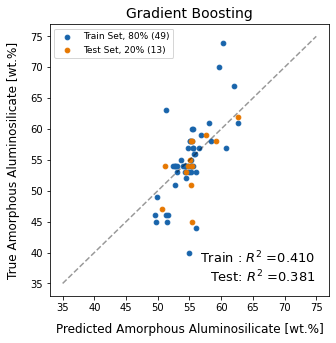

In [164]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(train_pred, redo_y_train, color='#1864AB', label='Train Set, 80% (49)', s=22)
ax.scatter(test_pred, redo_y_test, color='#E67700', label='Test Set, 20% (13)', s=22)

font = {'size':12}
font2 = {'size':14}
ax.set_xlabel("Predicted Amorphous Aluminosilicate [wt.%]", labelpad=10, fontdict=font)
ax.set_ylabel("True Amorphous Aluminosilicate [wt.%]", labelpad=10, fontdict=font)
ax.set_title('Gradient Boosting', fontdict=font2)
ax.legend(fontsize=9, loc="upper left")

# y=x dashed line
ax.plot([35,75], [35,75], c="k", linestyle='--',alpha=0.4)

ax.text(0.95, 0.05, f"Train : $R^2$ ={r2_score(redo_y_train, train_pred):0.3f}\nTest: $R^2$ ={r2_score(redo_y_test, test_pred):0.3f}",
        transform=ax.transAxes, fontsize=13, ha="right")

plt.savefig(f"./GradientBoostingRegressor_performance.png")

##### 2. max_depth, min_samples_split

In [73]:
index = []
for i in [ 2, 5, 10, 25, 50, 75, 100 ]:   # min_samples_split
  index.append('min_samples_split={}'.format(i))

array_2d = [[0 for i in range(7)] for j in range(8)]  

df_result = pd.DataFrame(array_2d, columns=index)

n_columns = 0
n_rows = 0

for n_rows, i in enumerate([2, 4, 6, 8, 10, 12, 14, 16]):     # max_depth
  for n_columns, j in enumerate([ 2, 5, 10, 25, 50, 75, 100 ]):

      gbr3 = GradientBoostingRegressor(warm_start = True, random_state=10,
                                        n_estimators = 1000, learning_rate = 0.001, 
                                        max_depth = i, min_samples_split = j)

      df_result.iloc[n_rows,n_columns] = modelfit(gbr3, require_return=True, print_feature_importances_=False)


CV Score | Mean : 0.4194 | Std : 0.2165 | Min : 0.0202 | Max : 0.6301

CV Score | Mean : 0.3853 | Std : 0.2261 | Min : 0.0414 | Max : 0.6950

CV Score | Mean : 0.3853 | Std : 0.2261 | Min : 0.0414 | Max : 0.6950

CV Score | Mean : 0.3623 | Std : 0.2143 | Min : 0.0457 | Max : 0.6722

CV Score | Mean : -0.0328 | Std : 0.0367 | Min : -0.0989 | Max : -0.0007

CV Score | Mean : -0.0328 | Std : 0.0367 | Min : -0.0989 | Max : -0.0007

CV Score | Mean : -0.0328 | Std : 0.0367 | Min : -0.0989 | Max : -0.0007

CV Score | Mean : 0.5779 | Std : 0.3463 | Min : -0.1087 | Max : 0.8328

CV Score | Mean : 0.5282 | Std : 0.3524 | Min : -0.1657 | Max : 0.8179

CV Score | Mean : 0.4822 | Std : 0.3063 | Min : -0.0825 | Max : 0.7597

CV Score | Mean : 0.4215 | Std : 0.2502 | Min : -0.0086 | Max : 0.6840

CV Score | Mean : -0.0328 | Std : 0.0367 | Min : -0.0989 | Max : -0.0007

CV Score | Mean : -0.0328 | Std : 0.0367 | Min : -0.0989 | Max : -0.0007

CV Score | Mean : -0.0328 | Std : 0.0367 | Min : -0.0989 

In [74]:
df_result.index = [i for i in [2, 4, 6, 8, 10, 12, 14, 16]]  
df_result

,min_samples_split=2,min_samples_split=5,min_samples_split=10,min_samples_split=25,min_samples_split=50,min_samples_split=75,min_samples_split=100
2,0.41936,0.38528,0.38528,0.36232,-0.03276,-0.03276,-0.03276
4,0.57786,0.52824,0.48218,0.42150,-0.03276,-0.03276,-0.03276
6,0.63540,0.58578,0.51370,0.45174,-0.03276,-0.03276,-0.03276
8,0.63866,0.58764,0.53280,0.46526,-0.03276,-0.03276,-0.03276
10,0.64108,0.58704,0.54604,0.46526,-0.03276,-0.03276,-0.03276
12,0.64108,0.58708,0.54660,0.46526,-0.03276,-0.03276,-0.03276
14,0.64108,0.58708,0.54660,0.46526,-0.03276,-0.03276,-0.03276
16,0.64108,0.58708,0.54660,0.46526,-0.03276,-0.03276,-0.03276


In [75]:
df_result.max()

min_samples_split=2      0.64108
min_samples_split=5      0.58764
min_samples_split=10     0.54660
min_samples_split=25     0.46526
min_samples_split=50    -0.03276
min_samples_split=75    -0.03276
min_samples_split=100   -0.03276
dtype: float64

In [76]:
gbr3 = GradientBoostingRegressor(warm_start = True, random_state=10,
                                  n_estimators = 1000, learning_rate =0.001 , 
                                  max_depth = 10, min_samples_split = 2)

modelfit(gbr3, performCV=False, print_feature_importances_=False)

train r2_score :  0.8648000746025003
test r2_score :  -0.2924421685199099


심한 과적합

In [77]:
gbr3 = GradientBoostingRegressor(warm_start = True, random_state=10,
                                  n_estimators = 1000, learning_rate =0.001 , 
                                  max_depth = 2, min_samples_split = 25)

modelfit(gbr3, performCV=False, print_feature_importances_=False)

train r2_score :  0.34548216008413624
test r2_score :  0.3658288282952371


해당 파라미터 조정은 과적합 모델을 만든다.

##### 3. max_features

In [78]:
gbr2

GradientBoostingRegressor(learning_rate=0.001, n_estimators=1000,
                          random_state=10, warm_start=True)

In [79]:
result = []

for i in [1,2,3,4,5,6] :     # max_feature
  gbr4 = GradientBoostingRegressor(warm_start = True, random_state=10,
                                    n_estimators = 1000, learning_rate = 0.001, 
                                    max_features = i)
  

  result.append(modelfit(gbr4, require_return=True, print_feature_importances_=False))

  print('max_features =',i, '에 대한 성능이다.')
  print('=====================================================================\n')


CV Score | Mean : 0.4277 | Std : 0.2645 | Min : -0.0787 | Max : 0.6419
max_features = 1 에 대한 성능이다.


CV Score | Mean : 0.4688 | Std : 0.2620 | Min : -0.0299 | Max : 0.6962
max_features = 2 에 대한 성능이다.


CV Score | Mean : 0.4963 | Std : 0.2530 | Min : 0.0076 | Max : 0.7286
max_features = 3 에 대한 성능이다.


CV Score | Mean : 0.5080 | Std : 0.2664 | Min : -0.0121 | Max : 0.7491
max_features = 4 에 대한 성능이다.


CV Score | Mean : 0.5102 | Std : 0.2752 | Min : -0.0266 | Max : 0.7599
max_features = 5 에 대한 성능이다.


CV Score | Mean : 0.5145 | Std : 0.2790 | Min : -0.0288 | Max : 0.7645
max_features = 6 에 대한 성능이다.



In [80]:
result

[0.42768000000000006, 0.4688, 0.4963, 0.5080199999999999, 0.5102, 0.5145]

성능이 좋아지지 않았다.

따라서 gbr2 모델 성능인 0.5145 가 가장 높은 모델이다.

### Random Forest

배깅방법을 결정트리에 활용한 앙상블 방법

다수의 나무를 기반으로 예측하기 때문에, 개별의 나무의 영향력이 줄어들게 되어 좋은 일반화 성능을 보인다.

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때, 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다. 편향을 손해보는 대신 분산을 낮춘다. (편향-분산 트레이드오프)

Default |

- n_estimators = 100
  
  일반적으로 높이면 성능이 높아지나, 성능 대비 시간효율 떨어질 수 있음

- min_samples_split = 2

  노드를 분할하기 위한 최소한의 샘플 수

  작게 설정할수록, 분할노드가 많아져 과적합 우려

- min_samples_leaf = 1
  
  리프노드가 되기 위해 필요한 최소한의 샘플 수

  min_samples_split 과 함께 과적합 제어에 사용

  *불균형 데이터의 경우, 특정 클래스의 데이터가 극도로 작을 수 있으므로 작게 설정 해야함*

- max_features = auto

  최적의 분할을 위해 고려한 최대 feature 개수

- max_depth = None

  트리의 최대깊이


#### default start

In [81]:
Rf1 = RandomForestRegressor(random_state=10)

modelfit(Rf1, print_feature_importances_=False)


CV Score | Mean : -0.0321 | Std : 0.3822 | Min : -0.4310 | Max : 0.5317


In [82]:
Rf1 = RandomForestRegressor(warm_start=True, random_state=10)

modelfit(Rf1, print_feature_importances_=False)


CV Score | Mean : 0.6391 | Std : 0.4503 | Min : -0.2594 | Max : 0.9207


In [83]:
modelfit(Rf1, performCV=False, print_feature_importances_=False)

train r2_score :  0.6026970450976973
test r2_score :  0.18842467859139167


과적합 모델이다.

#### Hyperparameter Tuning

##### 1. n_estimators

일종의 voting 방법이니까, 조기종료하면 안 될 것으로 보임

In [84]:
# n_estimators : [ 20, 50, 100, 125, 150, 175,  200, 500, 1000]

result = []

for i in [ 20, 50, 100, 125, 150, 175,  200, 500, 1000]:
  Rf2 = RandomForestRegressor(warm_start=True, random_state=10,
                              n_estimators=i)
                              
  result.append(modelfit(Rf2, require_return=True, print_feature_importances_=False))
 
  print('n_estimators =',i, '에 대한 성능이다.')
  print('=====================================================================\n')



CV Score | Mean : 0.6569 | Std : 0.3763 | Min : -0.0863 | Max : 0.9398
n_estimators = 20 에 대한 성능이다.


CV Score | Mean : 0.6281 | Std : 0.4539 | Min : -0.2765 | Max : 0.9185
n_estimators = 50 에 대한 성능이다.


CV Score | Mean : 0.6391 | Std : 0.4503 | Min : -0.2594 | Max : 0.9207
n_estimators = 100 에 대한 성능이다.


CV Score | Mean : 0.6301 | Std : 0.4477 | Min : -0.2638 | Max : 0.9007
n_estimators = 125 에 대한 성능이다.


CV Score | Mean : 0.6277 | Std : 0.4450 | Min : -0.2602 | Max : 0.9069
n_estimators = 150 에 대한 성능이다.


CV Score | Mean : 0.6230 | Std : 0.4432 | Min : -0.2615 | Max : 0.8989
n_estimators = 175 에 대한 성능이다.


CV Score | Mean : 0.6271 | Std : 0.4431 | Min : -0.2569 | Max : 0.9076
n_estimators = 200 에 대한 성능이다.


CV Score | Mean : 0.6391 | Std : 0.4325 | Min : -0.2233 | Max : 0.9188
n_estimators = 500 에 대한 성능이다.


CV Score | Mean : 0.6439 | Std : 0.4293 | Min : -0.2122 | Max : 0.9202
n_estimators = 1000 에 대한 성능이다.



In [85]:
result

[0.65694,
 0.62808,
 0.63914,
 0.63014,
 0.6276599999999999,
 0.623,
 0.62708,
 0.6391,
 0.6439199999999999]

In [86]:
Rf2 = RandomForestRegressor(warm_start=True, random_state=10,
                            n_estimators=150)

# test set checking
modelfit(Rf2, performCV=False, print_feature_importances_=False)

train r2_score :  0.8297401498410485
test r2_score :  0.17365505248121182


해당 튜닝 모두 과적합

##### 2. max depth, min_samples_split

In [87]:
index = []
for i in [ 10, 15, 20, 25, 30, 35, 40, 45, 50 ]:   # min_samples_split
  index.append('min_samples_split={}'.format(i))

array_2d = [[0 for i in range(9)] for j in range(8)]  

df_result = pd.DataFrame(array_2d, columns=index)

n_columns = 0
n_rows = 0

for n_rows, i in enumerate([2, 4, 6, 8, 10, 12, 14, 16]):     # max_depth
  for n_columns, j in enumerate([ 10, 15, 20, 25, 30, 35, 40, 45, 50 ]):

      Rf3 = RandomForestRegressor(warm_start=True, random_state=10,
                                   max_depth =i, min_samples_split =j)

      df_result.iloc[n_rows,n_columns] = modelfit(Rf3, require_return=True, print_feature_importances_=False)


CV Score | Mean : 0.3769 | Std : 0.2640 | Min : -0.0697 | Max : 0.7392

CV Score | Mean : 0.3632 | Std : 0.2664 | Min : -0.0693 | Max : 0.7518

CV Score | Mean : 0.3361 | Std : 0.2580 | Min : -0.0498 | Max : 0.7416

CV Score | Mean : 0.1851 | Std : 0.1806 | Min : -0.0221 | Max : 0.5051

CV Score | Mean : -0.0255 | Std : 0.0341 | Min : -0.0841 | Max : 0.0145

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : 0.4356 | Std : 0.3440 | Min : -0.2230 | Max : 0.7648

CV Score | Mean : 0.4195 | Std : 0.3203 | Min : -0.1727 | Max : 0.7738

CV Score | Mean : 0.3725 | Std : 0.2723 | Min : -0.0641 | Max : 0.7683

CV Score | Mean : 0.1870 | Std : 0.1798 | Min : -0.0204 | Max : 0.5053

CV Score | Mean : -0.0255 | Std : 0.0341 | Min : -0.08

In [88]:
df_result.index = [i for i in [2, 4, 6, 8, 10, 12, 14, 16]]  
df_result

,min_samples_split=10,min_samples_split=15,min_samples_split=20,min_samples_split=25,min_samples_split=30,min_samples_split=35,min_samples_split=40,min_samples_split=45,min_samples_split=50
2,0.37692,0.36318,0.33612,0.18506,-0.0255,-0.0302,-0.0302,-0.0302,-0.0302
4,0.43560,0.41954,0.37252,0.18702,-0.0255,-0.0302,-0.0302,-0.0302,-0.0302
6,0.45140,0.42276,0.37690,0.18702,-0.0255,-0.0302,-0.0302,-0.0302,-0.0302
8,0.45466,0.42510,0.37690,0.18702,-0.0255,-0.0302,-0.0302,-0.0302,-0.0302
10,0.45554,0.42538,0.37690,0.18702,-0.0255,-0.0302,-0.0302,-0.0302,-0.0302
12,0.45574,0.42538,0.37690,0.18702,-0.0255,-0.0302,-0.0302,-0.0302,-0.0302
14,0.45574,0.42538,0.37690,0.18702,-0.0255,-0.0302,-0.0302,-0.0302,-0.0302
16,0.45574,0.42538,0.37690,0.18702,-0.0255,-0.0302,-0.0302,-0.0302,-0.0302


In [89]:
df_result.max()

min_samples_split=10    0.45574
min_samples_split=15    0.42538
min_samples_split=20    0.37690
min_samples_split=25    0.18702
min_samples_split=30   -0.02550
min_samples_split=35   -0.03020
min_samples_split=40   -0.03020
min_samples_split=45   -0.03020
min_samples_split=50   -0.03020
dtype: float64

In [90]:
Rf3 = RandomForestRegressor(warm_start=True, random_state=10,
                              max_depth =4, min_samples_split =10)

modelfit(Rf3, print_feature_importances_=False), modelfit(Rf3, performCV=False, print_feature_importances_=False)


CV Score | Mean : 0.4356 | Std : 0.3440 | Min : -0.2230 | Max : 0.7648
train r2_score :  0.4101009145164517
test r2_score :  0.38059301853533456


(None, None)

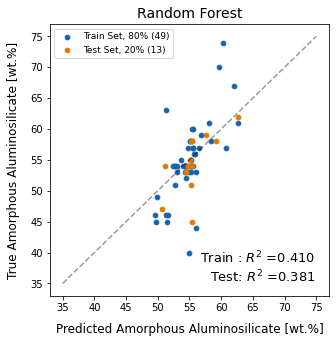

In [163]:
train_pred = Rf3.predict(X_train).reshape(-1,1)
train_pred = scalery.inverse_transform(train_pred)

redo_y_train = scalery.inverse_transform(y_train.values.reshape(-1,1))

test_pred = Rf3.predict(X_test).reshape(-1,1)
test_pred = scalery.inverse_transform(test_pred)

redo_y_test = scalery.inverse_transform(y_test.values.reshape(-1,1))

fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(train_pred, redo_y_train, color='#1864AB', label='Train Set, 80% (49)', s=22)
ax.scatter(test_pred, redo_y_test, color='#E67700', label='Test Set, 20% (13)', s=22)

font = {'size':12}
font2 = {'size':14}
ax.set_xlabel("Predicted Amorphous Aluminosilicate [wt.%]", labelpad=10, fontdict=font)
ax.set_ylabel("True Amorphous Aluminosilicate [wt.%]", labelpad=10, fontdict=font)
ax.set_title('Random Forest', fontdict=font2)
ax.legend(fontsize=9, loc="upper left")

# y=x dashed line
ax.plot([35,75], [35,75], c="k", linestyle='--',alpha=0.4)

ax.text(0.95, 0.05, f"Train : $R^2$ ={r2_score(redo_y_train, train_pred):0.3f}\nTest: $R^2$ ={r2_score(redo_y_test, test_pred):0.3f}",
        transform=ax.transAxes, fontsize=13, ha="right")

plt.savefig(f"./RandomForest_performance.png")

Performance is improved.

##### 3. max_features, min_samples_leaf

In [92]:
index = []
for i in [ 10, 15, 20, 25, 30, 35, 40, 45, 50 ]:   # min_samples_leaf
  index.append('min_samples_split={}'.format(i))

array_2d = [[0 for i in range(9)] for j in range(5)]  

df_result = pd.DataFrame(array_2d, columns=index)

n_columns = 0
n_rows = 0

for n_rows, i in enumerate([2, 3, 4, 5, 6]):     # max_features
  for n_columns, j in enumerate([ 10, 15, 20, 25, 30, 35, 40, 45, 50 ]):

      Rf4 = RandomForestRegressor(warm_start=True, random_state=10,
                                   max_depth =6, min_samples_split =10,
                                   max_features=i, min_samples_leaf=j)

      df_result.iloc[n_rows,n_columns] = modelfit(Rf4, require_return=True, print_feature_importances_=False)


CV Score | Mean : 0.0879 | Std : 0.0853 | Min : -0.0436 | Max : 0.2208

CV Score | Mean : -0.0293 | Std : 0.0294 | Min : -0.0814 | Max : -0.0008

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : 0.1039 | Std : 0.1040 | Min : -0.0577 | Max : 0.2661

CV Score | Mean : -0.0293 | Std : 0.0294 | Min : -0.0814 | Max : -0.0008

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : -0.0302 | Std : 0.0302 | Min : -0.0851 | Max : -0.0028

CV Score | Mean : -0.0302 | Std : 0.0302 

In [93]:
df_result.index = [i for i in [2, 3, 4, 5, 6]]  
df_result

,min_samples_split=10,min_samples_split=15,min_samples_split=20,min_samples_split=25,min_samples_split=30,min_samples_split=35,min_samples_split=40,min_samples_split=45,min_samples_split=50
2,0.08788,-0.02926,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302
3,0.10390,-0.02926,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302
4,0.11702,-0.02926,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302
5,0.13108,-0.02926,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302
6,0.13446,-0.02926,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302,-0.0302


In [94]:
df_result.max()

min_samples_split=10    0.13446
min_samples_split=15   -0.02926
min_samples_split=20   -0.03020
min_samples_split=25   -0.03020
min_samples_split=30   -0.03020
min_samples_split=35   -0.03020
min_samples_split=40   -0.03020
min_samples_split=45   -0.03020
min_samples_split=50   -0.03020
dtype: float64

성능이 좋아지지 않음

##### 4. Retuning n_estimators

In [95]:
result = []

for i in [ 20, 50, 75, 100, 125, 150, 175,  200, 500, 1000]:       # n_estimators
  Rf5 = RandomForestRegressor(max_depth=6, min_samples_split=10, random_state=10, warm_start=True,
                              n_estimators=i)
                              
  result.append(modelfit(Rf5, require_return=True, print_feature_importances_=False))
 
  print('n_estimators =',i, '에 대한 성능이다.')
  print('=====================================================================\n')


CV Score | Mean : 0.4266 | Std : 0.2924 | Min : -0.1351 | Max : 0.7138
n_estimators = 20 에 대한 성능이다.


CV Score | Mean : 0.4276 | Std : 0.3889 | Min : -0.3306 | Max : 0.7663
n_estimators = 50 에 대한 성능이다.


CV Score | Mean : 0.4367 | Std : 0.3809 | Min : -0.3029 | Max : 0.7737
n_estimators = 75 에 대한 성능이다.


CV Score | Mean : 0.4514 | Std : 0.3892 | Min : -0.3037 | Max : 0.8021
n_estimators = 100 에 대한 성능이다.


CV Score | Mean : 0.4483 | Std : 0.3806 | Min : -0.2881 | Max : 0.7907
n_estimators = 125 에 대한 성능이다.


CV Score | Mean : 0.4522 | Std : 0.3834 | Min : -0.2826 | Max : 0.8225
n_estimators = 150 에 대한 성능이다.


CV Score | Mean : 0.4450 | Std : 0.3869 | Min : -0.3002 | Max : 0.8081
n_estimators = 175 에 대한 성능이다.


CV Score | Mean : 0.4496 | Std : 0.3862 | Min : -0.2932 | Max : 0.8155
n_estimators = 200 에 대한 성능이다.


CV Score | Mean : 0.4717 | Std : 0.3746 | Min : -0.2377 | Max : 0.8540
n_estimators = 500 에 대한 성능이다.


CV Score | Mean : 0.4810 | Std : 0.3622 | Min : -0.2050 | Max : 0.8545
n_es

In [96]:
result

[0.42664,
 0.42758,
 0.43674,
 0.4514,
 0.44833999999999996,
 0.45215999999999995,
 0.445,
 0.44960000000000006,
 0.47169999999999995,
 0.48103999999999997]

성능 향상되지 않음

### XGBoost

GadientBoosting 에서 개선된 알고리즘으로, 병렬처리를 지원하며 가지치기 방식이라는 점에 다르다.

XGBoost의 하이퍼파라미터는 세 가지로 분류할 수 있다.

- 일반 파라미터
  : 부스팅을 수행할 때 트리를 사용할지, 선형 모델을 사용할지 선택

- 부스터 파라미터
  : 선택한 부스터에 따라서 적용할 수 있는 파라미터

- 학습 과정 파라미터
  : 학습 시나리오를 결정

Default | 

1. 일반 파라미터

- booster = gbtree (어떤 부스터를 쓸 지) (gbtree, 의사결정기반모형 / gblinear, 선형모형 / dart)

- n_jobs (XGBoost를 실행하는데 사용되는 병령 스레드 수)

- verbosity = 1 (0, 무음 / 1, 경고 / 2, 정보 / 3, 디버그)


2. 부스터 파라미터(gbtree 일 때)

- learning_rate = 3  (높을수록 과적합 우려)

- n_estimators = 100 (learning_rate가 낮을 땐, n_estimators를 높여야 한다)

- max_depth = 6 **(사이킷런래퍼는 3이 default)** ( 보통 range 3-10) (높을수록 과적합 우려)

- min_child_weight = 1 ( 관측치?에 대한 가중치 합의 최소 ) (높을수록 과적합 방지)

- gamma = 0 (리프노드의 추가분할을 결정할 최소손실 감소값으로, 해당값보다 손실이 크게 감소할 때 분리한다) (높을수록 과적합 방지)

- subsample =1 (데이터 샘플링 비율) (보통 range0.5-1) (낮을수록 과적합 방지)

- colsample_bytree = 1 (각 tree별 사용된 feature의 퍼센테이지) (range 0.5-1) (낮을수록 과적합 방지)

- lambda = 1 ( 가줃치에 대한 L2 Regularization ) (피처 개수가 많을 때 적용 검토) ( 클수록 과적합 방지 )

- alpha = 0 ( 가중치에 대한 L1 Regularization ) ( 동일)



3. 학습과정 파라미터

- eval_metric (평가함수)

- objective (목적함수)



---


민감하게 조정해야하는 것

- booster 모양

- eval_metric(평가함수) / objective(목적함수)

- learning_rate

- L1 form (L1 레귤러라이제이션 폼이 L2보다 아웃라이어에 민감하다.)

- L2 form


---

과적합 방지를 위해 조정해야하는 것

- learning rate 낮추기 → n_estimators은 높여야함

- max_depth 낮추기

- min_child_weight 높이기

- gamma 높이기

- subsample, colsample_bytree 낮추기

Xgb default

In [97]:
default_xgb = XGBRegressor(random_state=42)


modelfit(default_xgb, print_feature_importances_=False)

[17:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

CV Score | Mean : -0.8912 | Std : 0.4802 | Min : -1.8140 | Max : -0.5404


#### Hyperparameters Tuning

###### def method

In [98]:
def xgb_modelfit(alg, early_stopping_useTrainCV=True, eval_metric='rmse', 
                 performCV=True, cv_folds=5, 
                 early_stopping_rounds=50, require_return=False):
    
    if early_stopping_useTrainCV:            # 사이킷런래퍼에 cv() API 제공 안하므로
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, y_train)    
        cvresult = xgb.cv(xgb_param,      # fiot
                          xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics=eval_metric, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])


    if performCV:
      return stratifiedCV(alg, return_cv = require_return)
      
    else:
      #Fit the algorithm on the data
      alg.fit(X_train, y_train)

      print("train r2_score : ", r2_score(y_train, alg.predict(X_train)))
      print("test r2_score : ", r2_score(y_test, alg.predict(X_test)))

###### 1. n_estimators, learning_rate

In [99]:
result = []

for i in [3, 1, 0.5, 0.1, 0.01 ]:
  xgb1 = XGBRegressor(booster='gbtree',
                      learning_rate = i,
                      n_estimators=1000,  # early stopping
                      random_state=42)

  xgb_modelfit(xgb1)
  result.append(modelfit(xgb1, require_return=True, print_feature_importances_=False))

[17:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [100]:
result

[-6.188840000000001,
 -0.13698000000000002,
 0.005479999999999996,
 0.004240000000000001,
 -0.007640000000000003]

In [101]:
xgb1 = XGBRegressor(booster='gbtree',
                    learning_rate = 0.1,
                    n_estimators=1000,  # early stopping
                    random_state=42)

xgb_modelfit(xgb1)
xgb1

[17:08:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

XGBRegressor(n_estimators=6, random_state=42)

In [102]:
xgb_modelfit(xgb1, performCV=False)

[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train r2_score :  0.2895067742958264
test r2_score :  0.08135969270194898


###### 2. max_depth, min_child_weight

In [103]:
# {'max_depth : range(3,10),    
#  'min_child_weight' : range(1,10) }
#  max_depth, 높을수록 과적합 우려  min_child_weight, 높을수록 과적합 방지

index = []
for i in range(1,11):
  index.append('min_child={}'.format(i))

array_2d = [[0 for i in range(10)] for j in range(8)]  # IndexError: iloc cannot enlarge its target object

df_result = pd.DataFrame(array_2d, columns=index)

for i in range(3,11):                   # max_depth     
  for j in range(1,11):                 # min_child_weight

    xgb2 = XGBRegressor(booster='gbtree',learning_rate = 0.1 ,n_estimators=6, 
                        max_depth=i, min_child_weight=j,
                        random_state=42)
    
    df_result.iloc[i-3,j-1] = xgb_modelfit(xgb2, early_stopping_useTrainCV=False, require_return=True)

    print('max_depth =',i, ', min_child_weight =', j, '에 대한 성능이다.')
    print('=====================================================================\n')


[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

CV Score | Mean : 0.0042 | Std : 0.2120 | Min : -0.2075 | Max : 0.3811
max_depth = 3 , min_child_weight = 1 에 대한 성능이다.

[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squa

In [104]:
df_result.index = [i for i in range(3,11)]  # df_result  index:max_depth, columns:min_child_weight
df_result

,min_child=1,min_child=2,min_child=3,min_child=4,min_child=5,min_child=6,min_child=7,min_child=8,min_child=9,min_child=10
3,0.00424,-0.04728,-0.05990,-0.04680,-0.06552,-0.11588,-0.10236,-0.09006,-0.0678,-0.04934
4,-0.08550,-0.10186,-0.07136,-0.05776,-0.10292,-0.14332,-0.11260,-0.09006,-0.0678,-0.04934
5,-0.09648,-0.11200,-0.07788,-0.09632,-0.10394,-0.13424,-0.11260,-0.09006,-0.0678,-0.04934
6,-0.12464,-0.11496,-0.10344,-0.09114,-0.10394,-0.13424,-0.11260,-0.09006,-0.0678,-0.04934
7,-0.13602,-0.13536,-0.10958,-0.09034,-0.10394,-0.13424,-0.11260,-0.09006,-0.0678,-0.04934
8,-0.14700,-0.12976,-0.10958,-0.09034,-0.10394,-0.13424,-0.11260,-0.09006,-0.0678,-0.04934
9,-0.14100,-0.13410,-0.10958,-0.09034,-0.10394,-0.13424,-0.11260,-0.09006,-0.0678,-0.04934
10,-0.14332,-0.13410,-0.10958,-0.09034,-0.10394,-0.13424,-0.11260,-0.09006,-0.0678,-0.04934


In [105]:
df_result.max()  # 성능은 절댓값이므로

min_child=1     0.00424
min_child=2    -0.04728
min_child=3    -0.05990
min_child=4    -0.04680
min_child=5    -0.06552
min_child=6    -0.11588
min_child=7    -0.10236
min_child=8    -0.09006
min_child=9    -0.06780
min_child=10   -0.04934
dtype: float64

xgb2 성능이 좋아지지 않았다.

###### 3.gamma

In [106]:
# gamma : 0, 0.1, 0.2, 0.3, 0.4

result = []

for i in range(0,5):
  xgb3 = XGBRegressor(booster='gbtree', n_estimators=6, learning_rate=0.1,
                      gamma = i/10.0, 
                      random_state=42)
    
  result.append(xgb_modelfit(xgb3, early_stopping_useTrainCV=False, require_return=True)) 

  print('gamma =',i/10.0, '에 대한 성능이다.')
  print('=====================================================================\n')

[17:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

CV Score | Mean : 0.0042 | Std : 0.2120 | Min : -0.2075 | Max : 0.3811
gamma = 0.0 에 대한 성능이다.

[17:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:26] WARN

In [107]:
result

[0.004240000000000001,
 0.004240000000000001,
 0.004280000000000001,
 0.00242,
 0.0002400000000000041]

gamma = 0.2 일때 성능이 아주 조금 상승한다.

In [108]:
xgb3 = XGBRegressor(booster='gbtree', n_estimators=6, learning_rate=0.1,
                    gamma = 0.2, 
                    random_state=42)
    

xgb_modelfit(xgb3, early_stopping_useTrainCV=False)

[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

CV Score | Mean : 0.0043 | Std : 0.2120 | Min : -0.2075 | Max : 0.3811


In [109]:
xgb_modelfit(xgb3, performCV=False)

[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train r2_score :  0.28730543332172764
test r2_score :  0.09038327192148699


xgb3 성능 조금 상승

###### 4. subsample, colsample_bytree

In [110]:
# { 'subsample': [i/10.0 for i in range(5,11)],   # 낮을수록 과적합 방지
#  'colsample_bytree': [i/10.0 for i in range(5,11)]}  # 낮을수록 과적합 방지

index = []
for i in range(5,11):
  index.append('colsample_bytree={}'.format(i/10.0))

array_2d = [[0 for i in range(6)] for j in range(6)]  # IndexError: iloc cannot enlarge its target object

df_result = pd.DataFrame(array_2d, columns=index)

for i in range(5,11):
  for j in range(5,11):
    xgb4 = XGBRegressor(booster='gbtree', n_estimators = 6, learning_rate=0.1, gamma = 0.2,
                        subsample = i/10.0, colsample_bytree = j/10.0,
                        random_state = 42)
    
    df_result.iloc[i-5,j-5] = xgb_modelfit(xgb4, early_stopping_useTrainCV=False, require_return=True)

    print('subsample =',i, ', colsample_bytree =', j, '에 대한 성능이다.')
    print('=====================================================================\n')


[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

CV Score | Mean : -0.0039 | Std : 0.1560 | Min : -0.1372 | Max : 0.2338
subsample = 5 , colsample_bytree = 5 에 대한 성능이다.

[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squ

In [111]:
df_result.index = [i/10.0 for i in range(5,11)]  # df_result  index:max_depth, columns:min_child_weight
df_result

,colsample_bytree=0.5,colsample_bytree=0.6,colsample_bytree=0.7,colsample_bytree=0.8,colsample_bytree=0.9,colsample_bytree=1.0
0.5,-0.00390,-0.00390,-0.01108,-0.01108,-0.00308,-0.02512
0.6,-0.00138,-0.00138,-0.02808,-0.02808,-0.00872,-0.03076
0.7,0.01550,0.01550,0.01670,0.01670,0.02534,0.02570
0.8,0.01560,0.01560,0.01652,0.01652,0.02710,0.03208
0.9,-0.00570,-0.00570,-0.00708,-0.00708,0.03626,0.00698
1.0,-0.05616,-0.05616,-0.02180,-0.02180,0.01130,0.00428


In [112]:
df_result.max()  # 성능은 절댓값이므로

colsample_bytree=0.5    0.01560
colsample_bytree=0.6    0.01560
colsample_bytree=0.7    0.01670
colsample_bytree=0.8    0.01670
colsample_bytree=0.9    0.03626
colsample_bytree=1.0    0.03208
dtype: float64

In [113]:
xgb4 = XGBRegressor(booster='gbtree', n_estimators = 6, learning_rate=0.1, gamma = 0.2,
                    subsample = 0.7, colsample_bytree = 0.9,
                    random_state = 42)
    

xgb_modelfit(xgb4,early_stopping_useTrainCV=False)

[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

CV Score | Mean : 0.0253 | Std : 0.2231 | Min : -0.1729 | Max : 0.4243


In [114]:
xgb_modelfit(xgb4, performCV=False)

[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train r2_score :  0.26141776130053895
test r2_score :  -0.09733418836514707


해당모델 튜닝 모두 과적합

###### 4. Regularization Parameters

In [115]:
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]

result = []

for i in [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10 ,100]:
  xgb5 = XGBRegressor(booster='gbtree', n_estimators=6, 
                      gamma = 0.2, 
                      reg_alpha =i ,
                      random_state=42)

  result.append(xgb_modelfit(xgb5, early_stopping_useTrainCV=False, require_return=True)) 

  print('reg_alpha =',i, '에 대한 성능이다.')
  print('=====================================================================\n')


[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

CV Score | Mean : 0.0043 | Std : 0.2120 | Min : -0.2075 | Max : 0.3811
reg_alpha = 1e-05 에 대한 성능이다.

[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:29

In [116]:
result

[0.004280000000000001,
 0.004319999999999996,
 0.004299999999999998,
 0.004319999999999996,
 0.004539999999999997,
 -0.0064,
 -0.14758,
 -0.4003]

xgb3 모델에서 성능차이 거의 없다.

### Support Vector Machine

분류(SVC), 회귀(SVR), 특이점판별(OneClassSVM)에 쓰이는 지도학습 머신러닝 방법이다.



#### Hyperparameter Tuning

- eplison (마진의 폭)

- kernel

- gamma

- C

In [117]:
svr1 = SVR()

modelfit(svr1, print_feature_importances_=False)


CV Score | Mean : -0.0850 | Std : 0.1361 | Min : -0.3160 | Max : 0.0818


###### 1.kernel = 'rbf' 인 경우

In [118]:
index = []
for i in [0.1, 0.5, 1, 10, 15, 20, 25]:
  index.append('C={}'.format(i))

array_2d = [[0 for i in range(7)] for j in range(4)]  # 4X7 행렬

df_result = pd.DataFrame(array_2d, columns=index)

n_columns=0
n_rows = 0

for i in [1e-1, 1e-2, 1e-3, 1e-4]:
  for j in [0.1, 0.5, 1, 10, 15, 20, 25]:
    svr2 = SVR( kernel='rbf',
               gamma=i, C=j)
    
    df_result.iloc[n_rows, n_columns] = modelfit(svr2, require_return=True, print_feature_importances_=False)
    n_columns += 1

    print('gamma =',i, ', C =', j, '에 대한 성능이다.')
    print('=====================================================================\n')
  
  n_rows += 1
  n_columns =0



CV Score | Mean : -0.0437 | Std : 0.0304 | Min : -0.0793 | Max : -0.0043
gamma = 0.1 , C = 0.1 에 대한 성능이다.


CV Score | Mean : -0.0842 | Std : 0.0785 | Min : -0.1498 | Max : 0.0135
gamma = 0.1 , C = 0.5 에 대한 성능이다.


CV Score | Mean : -0.1073 | Std : 0.1248 | Min : -0.3113 | Max : 0.0342
gamma = 0.1 , C = 1 에 대한 성능이다.


CV Score | Mean : -0.6611 | Std : 0.4518 | Min : -1.4879 | Max : -0.1693
gamma = 0.1 , C = 10 에 대한 성능이다.


CV Score | Mean : -0.9871 | Std : 0.6962 | Min : -2.3280 | Max : -0.3167
gamma = 0.1 , C = 15 에 대한 성능이다.


CV Score | Mean : -1.3376 | Std : 0.9733 | Min : -3.2280 | Max : -0.4151
gamma = 0.1 , C = 20 에 대한 성능이다.


CV Score | Mean : -1.7821 | Std : 1.4257 | Min : -4.5188 | Max : -0.3782
gamma = 0.1 , C = 25 에 대한 성능이다.


CV Score | Mean : -0.0302 | Std : 0.0069 | Min : -0.0394 | Max : -0.0199
gamma = 0.01 , C = 0.1 에 대한 성능이다.


CV Score | Mean : -0.0385 | Std : 0.0450 | Min : -0.1101 | Max : 0.0039
gamma = 0.01 , C = 0.5 에 대한 성능이다.


CV Score | Mean : -0.0383 | Std : 

In [119]:
df_result.index = [1e-1, 1e-2, 1e-3, 1e-4]
df_result

,C=0.1,C=0.5,C=1,C=10,C=15,C=20,C=25
0.1000,-0.04368,-0.08418,-0.10730,-0.66108,-0.98710,-1.33764,-1.78210
0.0100,-0.03020,-0.03854,-0.03834,-0.14516,-0.20640,-0.32422,-0.41404
0.0010,-0.02862,-0.02886,-0.02930,-0.02392,-0.02750,-0.03180,-0.03518
0.0001,-0.02862,-0.02862,-0.02860,-0.02918,-0.02978,-0.03010,-0.03104


In [120]:
df_result.max()

C=0.1   -0.02862
C=0.5   -0.02862
C=1     -0.02860
C=10    -0.02392
C=15    -0.02750
C=20    -0.03010
C=25    -0.03104
dtype: float64

c=10, gamma=0.0001 일 때 성능이 낫다.

In [121]:
svr2 = SVR( kernel='rbf', gamma=0.001, C=10)

modelfit(svr2, print_feature_importances_=False)


CV Score | Mean : -0.0239 | Std : 0.0825 | Min : -0.1635 | Max : 0.0720


In [122]:
modelfit(svr2, performCV=False, print_feature_importances_=False)

train r2_score :  0.05031580645126876
test r2_score :  0.138699358740749


###### 2.kernel = 'sigmoid' 인 경우

In [123]:
index = []
for i in [0.1, 0.5, 1, 10, 15, 20, 25]:
  index.append('C={}'.format(i))

array_2d = [[0 for i in range(7)] for j in range(4)]  # 4X7 행렬

df_result = pd.DataFrame(array_2d, columns=index)

n_columns=0
n_rows = 0

for i in [1e-1, 1e-2, 1e-3, 1e-4]:
  for j in [0.1, 0.5, 1, 10, 15, 20, 25]:
    svr3 = SVR( kernel='sigmoid',
                gamma=i, C=j)
    
    df_result.iloc[n_rows, n_columns] = modelfit(svr3, require_return=True, print_feature_importances_=False)
    n_columns += 1

    print('gamma =',i, ', C =', j, '에 대한 성능이다.')
    print('=====================================================================\n')
  
  n_rows += 1
  n_columns =0



CV Score | Mean : -0.0342 | Std : 0.0493 | Min : -0.1135 | Max : 0.0172
gamma = 0.1 , C = 0.1 에 대한 성능이다.


CV Score | Mean : -0.0057 | Std : 0.0999 | Min : -0.1254 | Max : 0.1201
gamma = 0.1 , C = 0.5 에 대한 성능이다.


CV Score | Mean : -0.0098 | Std : 0.0950 | Min : -0.1184 | Max : 0.1540
gamma = 0.1 , C = 1 에 대한 성능이다.


CV Score | Mean : -2.5599 | Std : 3.6585 | Min : -9.7175 | Max : 0.5216
gamma = 0.1 , C = 10 에 대한 성능이다.


CV Score | Mean : -7.5438 | Std : 5.9948 | Min : -17.7825 | Max : -1.5088
gamma = 0.1 , C = 15 에 대한 성능이다.


CV Score | Mean : -17.2782 | Std : 14.7171 | Min : -39.9849 | Max : -2.1778
gamma = 0.1 , C = 20 에 대한 성능이다.


CV Score | Mean : -33.4033 | Std : 20.1760 | Min : -64.0015 | Max : -4.0941
gamma = 0.1 , C = 25 에 대한 성능이다.


CV Score | Mean : -0.0288 | Std : 0.0049 | Min : -0.0364 | Max : -0.0218
gamma = 0.01 , C = 0.1 에 대한 성능이다.


CV Score | Mean : -0.0310 | Std : 0.0295 | Min : -0.0778 | Max : 0.0031
gamma = 0.01 , C = 0.5 에 대한 성능이다.


CV Score | Mean : -0.0289 | S

In [124]:
df_result.index = [1e-1, 1e-2, 1e-3, 1e-4]
df_result

,C=0.1,C=0.5,C=1,C=10,C=15,C=20,C=25
0.1000,-0.03418,-0.00572,-0.00984,-2.55994,-7.54378,-17.27818,-33.40332
0.0100,-0.02880,-0.03100,-0.02886,-0.06494,-0.11942,-0.12962,-0.12784
0.0010,-0.02862,-0.02856,-0.02880,-0.02864,-0.02252,-0.02166,-0.02616
0.0001,-0.02860,-0.02856,-0.02862,-0.02880,-0.02898,-0.02918,-0.02944


In [125]:
df_result.max()

C=0.1   -0.02860
C=0.5   -0.00572
C=1     -0.00984
C=10    -0.02864
C=15    -0.02252
C=20    -0.02166
C=25    -0.02616
dtype: float64

c=0.5, gamma=0.1 일 때 성능이 낫다.

In [126]:
svr3 = SVR( kernel='sigmoid', gamma=0.1, C=0.5)

modelfit(svr3, print_feature_importances_=False)
modelfit(svr3, performCV=False, print_feature_importances_=False)


CV Score | Mean : -0.0057 | Std : 0.0999 | Min : -0.1254 | Max : 0.1201
train r2_score :  0.057053066939687924
test r2_score :  0.0714183959043665


svr3이 나음. 두 모델 모두 과적합 아님.

###### 3. 정밀한 튜닝, kernel = 'rbf' 인 경우

In [127]:
index = []
for i in [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]:  # C 파라미터
  index.append('C={}'.format(i))

array_2d = [[0 for i in range(8)] for j in range(5)]  # 5X8 행렬

df_result = pd.DataFrame(array_2d, columns=index)

n_columns=0
n_rows = 0

for i in [0.0001, 0.000025, 0.0000125, 0.0000125/2, 0.0000125/4]:  # gamma 파라미터
  for j in [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]:
    svr4 = SVR(kernel='rbf',
               gamma=i, C=j)
    
    df_result.iloc[n_rows, n_columns] = modelfit(svr4, require_return=True, print_feature_importances_=False)
    n_columns += 1

    print('gamma =',i, ', C =', j, '에 대한 성능이다.')
    print('=====================================================================\n')
  
  n_rows += 1
  n_columns =0



CV Score | Mean : -0.0286 | Std : 0.0076 | Min : -0.0355 | Max : -0.0158
gamma = 0.0001 , C = 0.025 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0075 | Min : -0.0355 | Max : -0.0159
gamma = 0.0001 , C = 0.05 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0075 | Min : -0.0355 | Max : -0.0159
gamma = 0.0001 , C = 0.075 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0075 | Min : -0.0355 | Max : -0.0160
gamma = 0.0001 , C = 0.1 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0074 | Min : -0.0354 | Max : -0.0161
gamma = 0.0001 , C = 0.125 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0074 | Min : -0.0354 | Max : -0.0161
gamma = 0.0001 , C = 0.15 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0074 | Min : -0.0354 | Max : -0.0162
gamma = 0.0001 , C = 0.175 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0073 | Min : -0.0352 | Max : -0.0163
gamma = 0.0001 , C = 0.2 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0076 | Min : -0.0355 | Max : -0.0157
gamma = 2.5e-05 , C = 0.025 

In [128]:
df_result.index = [0.0001, 0.000025, 0.0000125, 0.0000125/2, 0.0000125/4]
df_result

,C=0.025,C=0.05,C=0.075,C=0.1,C=0.125,C=0.15,C=0.175,C=0.2
0.000100,-0.02858,-0.02860,-0.02860,-0.02862,-0.02860,-0.02860,-0.02860,-0.02858
0.000025,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02860
0.000013,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858
0.000006,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858
0.000003,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858


In [129]:
df_result.max()

C=0.025   -0.02858
C=0.05    -0.02858
C=0.075   -0.02858
C=0.1     -0.02858
C=0.125   -0.02858
C=0.15    -0.02858
C=0.175   -0.02858
C=0.2     -0.02858
dtype: float64

svr4 성능이 나아지지 않았다.

###### 4. 정밀한 튜닝, kernel = 'simoid' 인 경우

In [130]:
index = []
for i in [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]:  # C 파라미터
  index.append('C={}'.format(i))

array_2d = [[0 for i in range(8)] for j in range(5)]  # 5X8 행렬

df_result = pd.DataFrame(array_2d, columns=index)

n_columns=0
n_rows = 0

for i in [0.0001, 0.000025, 0.0000125, 0.0000125/2, 0.0000125/4]:  # gamma 파라미터
  for j in [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]:
    svr5 = SVR(kernel='sigmoid',
               gamma=i, C=j)
    
    df_result.iloc[n_rows, n_columns] = modelfit(svr5, require_return=True, print_feature_importances_=False)
    n_columns += 1

    print('gamma =',i, ', C =', j, '에 대한 성능이다.')
    print('=====================================================================\n')
  
  n_rows += 1
  n_columns =0



CV Score | Mean : -0.0286 | Std : 0.0076 | Min : -0.0355 | Max : -0.0158
gamma = 0.0001 , C = 0.025 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0076 | Min : -0.0355 | Max : -0.0158
gamma = 0.0001 , C = 0.05 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0076 | Min : -0.0355 | Max : -0.0158
gamma = 0.0001 , C = 0.075 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0075 | Min : -0.0355 | Max : -0.0159
gamma = 0.0001 , C = 0.1 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0075 | Min : -0.0355 | Max : -0.0159
gamma = 0.0001 , C = 0.125 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0075 | Min : -0.0355 | Max : -0.0159
gamma = 0.0001 , C = 0.15 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0075 | Min : -0.0355 | Max : -0.0160
gamma = 0.0001 , C = 0.175 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0075 | Min : -0.0355 | Max : -0.0160
gamma = 0.0001 , C = 0.2 에 대한 성능이다.


CV Score | Mean : -0.0286 | Std : 0.0076 | Min : -0.0355 | Max : -0.0157
gamma = 2.5e-05 , C = 0.025 

In [131]:
df_result.index = [0.0001, 0.000025, 0.0000125, 0.0000125/2, 0.0000125/4]
df_result

,C=0.025,C=0.05,C=0.075,C=0.1,C=0.125,C=0.15,C=0.175,C=0.2
0.000100,-0.02858,-0.02858,-0.02858,-0.02860,-0.02860,-0.02860,-0.02862,-0.02862
0.000025,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858
0.000013,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858
0.000006,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858
0.000003,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858,-0.02858


In [132]:
df_result.max()

C=0.025   -0.02858
C=0.05    -0.02858
C=0.075   -0.02858
C=0.1     -0.02858
C=0.125   -0.02858
C=0.15    -0.02858
C=0.175   -0.02858
C=0.2     -0.02858
dtype: float64

svr3에서 성능이 나아지지 않았다.

### MLPRegression

#### Define Model

In [133]:
seed_value = 0

import numpy as np
import random as rn
import tensorflow as tf

rn.seed(seed_value)              # random에서 seed값 지정
np.random.seed(seed_value)       # np에서 seed값 지정
tf.compat.v1.set_random_seed(seed_value) # tensorflow에서 seed값 지정

In [134]:
dim = len(X_columns)

#### prat_train, valid 값으로 나누기

In [135]:
print(sc_strat_train['Sum of amorphous aluminosilicates Cat'].value_counts())

2    12
1    10
5    10
4     9
3     8
Name: Sum of amorphous aluminosilicates Cat, dtype: int64


In [136]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for mlp_train_index, mlp_valid_index in split.split(sc_strat_train, sc_strat_train['Sum of amorphous aluminosilicates Cat']):
  mlp_strat_train = sc_strat_train.loc[mlp_train_index]
  mlp_strat_valid = sc_strat_train.loc[mlp_valid_index]

In [137]:
print(mlp_strat_train.shape, mlp_strat_valid.shape)

(39, 8) (10, 8)


In [138]:
X_train_mlp = mlp_strat_train.iloc[:,0:6]
y_train_mlp = mlp_strat_train.iloc[:,6]

X_valid_mlp = mlp_strat_valid.iloc[:,0:6]
y_valid_mlp = mlp_strat_valid.iloc[:,6]

In [139]:
""" RandomSearchCV """
param_distribs = {
    'n_learning_rate' : reciprocal(3e-4, 3e-2).rvs(1000, random_state=21).tolist(),
}

#### Modeling

## Stacking

기본적인 스태킹 앙상블은 과적합(overfitting)의 문제점이 있어 사용하지 않는다. 보통 CV 기반(KFold 등)의 stacking ensemble을 사용한다.

#### 예제)

MetaModel.fit(stack_X_train, y_train)    # stack_X_train, 기반모델에서 valid data의 pred 값

result = MetaModel.predict(stack_X_test)     # stack_X_test, 기반모델에서 test data의 pred 값을 평균한 것


CV 기반 Stacking

In [140]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_absolute_error

# # 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
# def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
#     # 지정된 n_folds 값으로 KFold 생성
#     kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    
#     # 추후 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
#     train_fold_pred = np.zeros((X_train_n.shape[0], 1))
#     test_pred = np.zeros((X_test_n.shape[0], n_folds))
#     print(model.__class__.__name__,' model 시작')
    
#     for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
#         # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
#         print('\t 폴드 세트: ',folder_counter+1,' 시작')
#         X_tr = X_train_n[train_index]
#         y_tr = y_train_n[train_index]
#         X_te = X_train_n[valid_index]
        
#         # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
#         model.fit(X_tr, y_tr)
#         # 폴드 세트 내부에서 다시 만들어지 검증 데이터로 기반 모델 예측 후 데이터 저장
#         train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
#         # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
#         test_pred[:, folder_counter] = model.predict(X_test_n)
        
#     # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
#     test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
#     # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
#     return train_fold_pred, test_pred_mean

In [141]:
# knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
# rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
# dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
# ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

#### StratifiedKFold 기반 스태킹

In [142]:
# 메타모델이 사용할 학습 및 테스트용 데이터를 생성하는 함수
def get_stacking_based_stratified_for_data(model, n_folds=5):
  skf = StratifiedKFold(n_splits=n_folds)

  # 최종 모델에서 사용할 데이터 셋 셋팅(0 값으로) (각 기반모델마다 해당 함수 호출하므로..)
  train_fold_pred = np.zeros((strat_train.shape[0], 1))
  # 만약 shape가 (49,7) 이었으면 폴드의 검증과정에서 저장할 데이터는 (49,1) 모양을 갖게 한다. 
  # y값이니까
  # X_valid 를 n_folds번 실행하니까

  test_pred = np.zeros((strat_test.shape[0], n_folds))
  # test는 X_test값을 이용해서 매 폴드마다 예측을 하기 때문에 (100, 폴드수) 모양을 갖게 한다.
  # 이후에 값들을 평균할 것이다.

  print(model.__class__.__name__,' model 시작')


  for folder_cnt, (part_train_index, valid_index) in enumerate(skf.split(sc_strat_train, sc_strat_train['Sum of amorphous aluminosilicates Cat'])): 
      part_strat_train = sc_strat_train.loc[part_train_index]
      strat_valid = sc_strat_train.loc[valid_index]

      X_part_train = part_strat_train.iloc[:,0:6]
      y_part_train = pd.DataFrame(part_strat_train.iloc[:,6])

      X_valid = strat_valid.iloc[:,0:6]
      y_valid = pd.DataFrame(strat_valid.iloc[:,6])

      # Fitting
      model.fit(X_part_train, y_part_train)         # 기반 모델의 학습 수행
      train_fold_pred[valid_index, :] = model.predict(X_valid).reshape(-1,1) #  검증 데이터로, 기반 모델 예측
      test_pred[:, folder_cnt] = model.predict(X_test).reshape(1,-1)   

  # 각 폴드에서 X_test 값 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
  
  # 최종 메타 모델에서 사용할 학습 데이터, 테스트 데이터
  return train_fold_pred, test_pred_mean

 

In [143]:
models = [ 
          # sgd_reg,  # 0.0996
          gbr2,     # 0.5145
          Rf3,      # 0.4514
          # model4,   # 0.26   
          # model4_1  # 0.11   
                     
]

1) 기반모델 Fitting

In [144]:
S_train = pd.DataFrame()
S_test = pd.DataFrame()

for i, alg in enumerate(models):
  train, test = get_stacking_based_stratified_for_data(alg)
  S_train[i] = pd.DataFrame(train)
  S_test[i] = pd.DataFrame(test)

GradientBoostingRegressor  model 시작
RandomForestRegressor  model 시작


S_train, S_test 데이터 정리

In [145]:
# Size Check
print('원본 학습 데이터 크기 : ', X_train.shape, '원본 테스트 데이터 크기 : ', X_test.shape)
print('Stacking 학습 데이터 크기 : ', S_train.shape, 'Stacking 데이터 데이터 크기 : ', S_test.shape)

## 원본 데이터와 row 가 같고, column은 기반모델 개수와 같다.

원본 학습 데이터 크기 :  (49, 6) 원본 테스트 데이터 크기 :  (13, 6)
Stacking 학습 데이터 크기 :  (49, 2) Stacking 데이터 데이터 크기 :  (13, 2)


2) 메타모델 Fitting

In [146]:
final_model = LinearRegression()  # **MetaModel 조정

final_model.fit(S_train, y_train)
train_pred = final_model.predict(S_train)
final_pred = final_model.predict(S_test)

# print('최종 메타모델의 예측 정확도 : ', accuracy_score(y_test, final_pred))

In [147]:
# y_test = pd.DataFrame(y_test)
# final_pred = pd.DataFrame(final_pred.reshape(-1,1))
print('최종 메타모델의 예측 정확도 : ', r2_score(y_train, train_pred)) 
print('최종 메타모델의 예측 정확도 : ', r2_score(y_test,final_pred))    # 주의, model.score은 내부적으로 predict 후에 make_score

최종 메타모델의 예측 정확도 :  0.6643712203992223
최종 메타모델의 예측 정확도 :  0.49162657328250714


Text(0.5, 1.0, 'Actuals v Predicted')

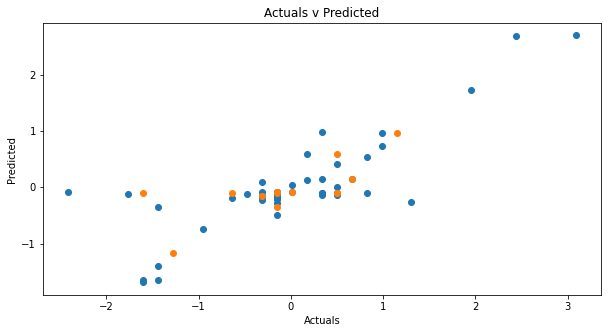

In [148]:
plt.figure(figsize=(10,5))
plt.scatter(y_train, final_model.predict(S_train))
plt.scatter(y_test, final_pred)
plt.xlabel("Actuals")
plt.ylabel("Predicted")
plt.title("Actuals v Predicted")

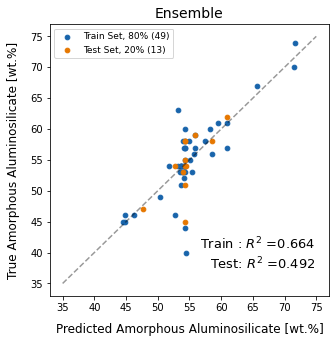

In [165]:
train_pred = final_model.predict(S_train).reshape(-1,1)
train_pred = scalery.inverse_transform(train_pred)

redo_y_train = scalery.inverse_transform(y_train.values.reshape(-1,1))

test_pred = final_model.predict(S_test).reshape(-1,1)
test_pred = scalery.inverse_transform(test_pred)

redo_y_test = scalery.inverse_transform(y_test.values.reshape(-1,1))

fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(train_pred, redo_y_train, color='#1864AB', label='Train Set, 80% (49)', s=22)
ax.scatter(test_pred, redo_y_test, color='#E67700', label='Test Set, 20% (13)', s=22)

font = {'size':12}
font2 = {'size':14}
ax.set_xlabel("Predicted Amorphous Aluminosilicate [wt.%]", labelpad=10, fontdict=font)
ax.set_ylabel("True Amorphous Aluminosilicate [wt.%]", labelpad=10, fontdict=font)
ax.set_title('Ensemble', fontdict=font2)
ax.legend(fontsize=9, loc="upper left")

# y=x dashed line
ax.plot([35,75], [35,75], c="k", linestyle='--',alpha=0.4)

ax.text(0.95, 0.1, f"Train : $R^2$ ={r2_score(redo_y_train, train_pred):0.3f}\nTest: $R^2$ ={r2_score(redo_y_test, test_pred):0.3f}",
        transform=ax.transAxes, fontsize=13, ha="right")

plt.savefig(f"./final_performance.png")

### Select ModelC Data

In [197]:
true_train = np.ravel(redo_y_train)
pred_train = np.ravel(train_pred)

true_test = np.ravel(redo_y_test)
pred_test = np.ravel(test_pred)

true = np.concatenate((true_train,true_test))
pred = np.concatenate((pred_train,pred_test))

In [206]:
idx = np.concatenate((train_idx, test_idx))

In [207]:
modelC = pd.DataFrame({'idx' : idx,
                        'true': true,
                        'pred': pred})
modelC.to_csv('modelC.csv')

In [208]:
modelC

,idx,true,pred
0,5,56.0,58.517208
1,1,58.0,57.520632
2,3,44.0,54.220079
3,16,63.0,53.251867
4,36,59.0,55.806341
...,...,...,...
57,24,58.0,54.332740
58,52,59.0,55.857063
59,57,55.0,54.373673
60,20,45.0,54.315680


In [203]:
train_idx

array([ 5,  1,  3, 16, 36, 58, 44, 61, 46, 23, 55, 56, 19, 34, 14, 18, 42,
       28,  7, 50, 12, 41, 25,  0, 38, 35, 22, 45, 13, 17, 40, 49, 29, 10,
       33, 26, 21,  2, 60, 54, 47, 31, 27,  4, 53, 11,  6,  8, 51])